## Kyaw Htet Paing Win

# Data Collection & Preparation Summary

1. Use historical flood events (2003, 2004, 2007, 2010, 2016, 2017) to create a dataset of balanced flood & non-flood data points.

2. The dataset includes weather-related features (eg: precipitation, soil, wind direction..) and topographical features (eg: DEM, Slope, Aspect). The target column is Flood/No Flood (Binary Classification Problem).

3. For each day (2013-2023), we have 512 data points (256 flood & 256 non-flood) at different geographic locations in Dhaka.  


**Meta data:**

NOTE: For all the features, I categorized them based on whether these features changed over time or not.

---

**Data Resolution: 30m**

* Year: Year **(Dynamic Feature)**

* DOY: Day of the Year **(Dynamic Feature)**

* T2M: Temperature at 2 Meters (C) - Average air temperature at 2 meters above the ground. **(Dynamic Feature)**

* T2M_RANGE: Temperature at 2 Meters Range (C) - Range of minimum and maximum hourly air temperature at 2 meters. **(Dynamic Feature)**

* T2M_MAX: Temperature at 2 Meters Maximum (C) - Maximum hourly air temperature at 2 meters. **(Dynamic Feature)**

* T2M_MIN: Temperature at 2 Meters Minimum (C) - Minimum hourly air temperature at 2 meters. **(Dynamic Feature)**

* QV2M: Specific Humidity at 2 Meters (g/kg) - Mass of water vapor per unit mass of air at 2 meters. **(Dynamic Feature)**

* RH2M: Relative Humidity at 2 Meters (%) - Relative humidity of the air at 2 meters. **(Dynamic Feature)**

* PRECTOTCORR: Precipitation Corrected (mm/day) - Bias-corrected total precipitation per day. **(Dynamic Feature)**

* WS2M: Wind Speed at 2 Meters (m/s) - Average wind speed at 2 meters above the ground. **(Dynamic Feature)**

* WS2M_MAX: Wind Speed at 2 Meters Maximum (m/s) - Maximum hourly wind speed at 2 meters. **(Dynamic Feature)**

* WS2M_MIN: Wind Speed at 2 Meters Minimum (m/s) - Minimum hourly wind speed at 2 meters. **(Dynamic Feature)**

* WS2M_RANGE: Wind Speed at 2 Meters Range (m/s) - Range of minimum and maximum hourly wind speed at 2 meters. **(Dynamic Feature)**

* WD2M: Wind Direction at 2 Meters (Degrees) - Average wind direction at 2 meters above the ground. **(Dynamic Feature)**

* PS: Surface Pressure (kPa) - Average surface atmospheric pressure. **(Dynamic Feature)**

* GWETTOP: Surface Soil Wetness - Percent of soil moisture, 0 indicating dry and 100 indicating saturation. **(Dynamic Feature)**

* GWETROOT: Root Zone Soil Wetness - Percent of root zone soil wetness, 0 indicating dry and 100 indicating saturation. **(Dynamic Feature)**

* GWETPROF: Profile Soil Moisture - Percent of profile soil moisture, 0 indicating dry and 100 indicating saturation. **(Dynamic Feature)**

* DEM: Digital Elevation Model - Represents the relief of the surface between points of known elevation. **(Static Feature)**

* Slope: Slope - Rate of change of elevation at each digital elevation grid cell. **(Static Feature)**

* Aspect: Aspect - Orientation of the slope, measured in degrees from North. **(Static Feature)**

* Latitude: Latitude - Geographic coordinate that specifies the north–south position. **(Static Feature)**

* Longitude: Longitude - Geographic coordinate that specifies the east-west position. **(Static Feature)**

# Imports

In [ ]:
!pip install prophet --quiet

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing for model development

In [ ]:
def combine_csv_files(file_dir, file_prefixes, set_type):
    """
    Combine CSV files for a specific dataset type (train, val, or test) into a
    single DataFrame and save it.

    :param file_dir: Directory where files are stored.
    :param file_prefixes: List of file prefixes (e.g., ['F', 'NF']).
    :param set_type: Type of dataset ('train', 'val', 'test').
    """
    combined_df = pd.DataFrame()
    selected_columns = ['YEAR',	'DOY',	'T2M', 'T2M_RANGE',	'T2M_MAX',
                        'T2M_MIN',	'QV2M',	'RH2M',	'PRECTOTCORR',	'WS2M',
                        'PS', 'WS2M_MAX', 'WS2M_MIN',	'WS2M_RANGE',	'WD2M',
                        'GWETTOP',	'GWETROOT', 'GWETPROF', 'latitude',
                        'longitude', 'DEM',	'Slope', 'Aspect', 'Flood/No Flood']
    for prefix in file_prefixes:
       # 256 flooded & non-flooded locations
        for i in range(1, 257):
            file_name = f"{prefix}{i}_with_rastervalues_Flood_NoFlood_imputed_3y_avg_{set_type}.csv"
            file_path = os.path.join(file_dir, file_name)
            if os.path.exists(file_path):
                df = pd.read_csv(file_path, usecols=selected_columns)
                combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Sorting the DataFrame
    combined_df.sort_values(by=['YEAR', 'DOY'], inplace=True)

    # Saving the combined DataFrame as a CSV file
    output_file = os.path.join(file_dir, f'combined_{set_type}.csv')
    combined_df.to_csv(output_file, index=False)
    print(f"Saved combined data for {set_type} to {output_file}")

In [ ]:
file_prefixes = ['F', 'NF']
train_dir = '/content/drive/MyDrive/GIS Data Analysis/train'
val_dir = '/content/drive/MyDrive/GIS Data Analysis/validation'
test_dir = '/content/drive/MyDrive/GIS Data Analysis/test'

In [ ]:
# # NOTE: Run only once to create combined csv files
# # Combine and save training data
# combine_csv_files(train_dir, file_prefixes, 'train')
# # Combine and save validation data
# combine_csv_files(val_dir, file_prefixes, 'validation')
# # Combine and save testing data
# combine_csv_files(test_dir, file_prefixes, 'test')

In [ ]:
# Load the combined train, val, test dataset
# NOTE: Seems to be mismatch with folder name for validaiton & test
# 2013-2019
train = pd.read_csv(train_dir + '/combined_train.csv')
# 2022-2023
val = pd.read_csv(val_dir + '/combined_validation.csv')
# 2020-2021
test = pd.read_csv(test_dir + '/combined_test.csv')

FileNotFoundError: ignored

In [ ]:
print(test['YEAR'].values.min())
print(test['YEAR'].values.max())

2020
2021


In [ ]:
print(val['YEAR'].values.min())
print(val['YEAR'].values.max())

2022
2023


In [ ]:
# To stack in the correct time-sequence order
df = pd.concat([train, test, val])

In [ ]:
# Sorting to make sure it's chronologically sorted
df = df.sort_values(by=["YEAR", "DOY"])

In [ ]:
# Add the target column as number
df['Flood'] = df['Flood/No Flood'].map({'F': 1, 'N': 0})

In [ ]:
# For time-related analysis create a Datetime column
df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + df['DOY'].astype(str), format='%Y%j')
df.head()

YEAR  DOY    T2M  T2M_RANGE  T2M_MAX  T2M_MIN  QV2M   RH2M  PRECTOTCORR  \
0  2013    1  16.55      14.43    24.88    10.45  7.57  67.00          0.0   
1  2013    1  16.55      14.43    24.88    10.45  7.57  67.00          0.0   
2  2013    1  16.55      14.43    24.88    10.45  7.57  67.00          0.0   
3  2013    1  17.13      13.39    24.43    11.04  7.39  62.94          0.0   
4  2013    1  15.87      14.62    23.77     9.15  7.26  66.75          0.0   

   WS2M  ...  GWETROOT  GWETPROF   latitude  longitude  DEM     Slope  Aspect  \
0  1.12  ...      0.55      0.53  24.311131  91.093680    6  0.656249   225.0   
1  1.12  ...      0.55      0.53  24.345349  90.970376    7  0.328135   315.0   
2  1.12  ...      0.55      0.53  24.416086  90.970907    2  0.000000     0.0   
3  1.46  ...      0.52      0.50  23.355901  90.384957    0  0.000000     0.0   
4  1.71  ...      0.51      0.50  24.398422  89.795676    7  0.000000     0.0   

   Flood/No Flood  Flood       Date  
0               F      1 2013-01-01  
1               F      1 2013-01-01  
2               F      1 2013-01-01  
3               F      1 2013-01-01  
4               F      1 2013-01-01  

[5 rows x 26 columns]

In [ ]:
# Setting the index as datetime column
df.set_index('Date', inplace=True)

In [ ]:
# Setting aside the copy for exploration
df_copy = df.copy()

In [ ]:
train = df_copy[(df_copy['YEAR'] >= 2013) & (df_copy['YEAR'] <= 2019)]
val = df_copy[(df_copy['YEAR'] >= 2020) & (df_copy['YEAR'] <= 2021)]
test = df_copy[(df_copy['YEAR'] >= 2022) & (df_copy['YEAR'] <= 2023)]

# Exploratory Data Analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1308672 entries, 2013-01-01 to 2019-12-31
Data columns (total 25 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   YEAR            1308672 non-null  int64  
 1   DOY             1308672 non-null  int64  
 2   T2M             1308672 non-null  float64
 3   T2M_RANGE       1308672 non-null  float64
 4   T2M_MAX         1308672 non-null  float64
 5   T2M_MIN         1308672 non-null  float64
 6   QV2M            1308672 non-null  float64
 7   RH2M            1308672 non-null  float64
 8   PRECTOTCORR     1308672 non-null  float64
 9   WS2M            1308672 non-null  float64
 10  PS              1308672 non-null  float64
 11  WS2M_MAX        1308672 non-null  float64
 12  WS2M_MIN        1308672 non-null  float64
 13  WS2M_RANGE      1308672 non-null  float64
 14  WD2M            1308672 non-null  float64
 15  GWETTOP         1308672 non-null  float64
 16  GWETROOT        13086

In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374272 entries, 2020-01-01 to 2021-12-31
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   YEAR            374272 non-null  int64  
 1   DOY             374272 non-null  int64  
 2   T2M             374272 non-null  float64
 3   T2M_RANGE       374272 non-null  float64
 4   T2M_MAX         374272 non-null  float64
 5   T2M_MIN         374272 non-null  float64
 6   QV2M            374272 non-null  float64
 7   RH2M            374272 non-null  float64
 8   PRECTOTCORR     374272 non-null  float64
 9   WS2M            374272 non-null  float64
 10  PS              374272 non-null  float64
 11  WS2M_MAX        374272 non-null  float64
 12  WS2M_MIN        374272 non-null  float64
 13  WS2M_RANGE      374272 non-null  float64
 14  WD2M            374272 non-null  float64
 15  GWETTOP         374272 non-null  float64
 16  GWETROOT        374272 non-null  float64

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350208 entries, 2022-01-01 to 2023-11-15
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   YEAR            350208 non-null  int64  
 1   DOY             350208 non-null  int64  
 2   T2M             350208 non-null  float64
 3   T2M_RANGE       350208 non-null  float64
 4   T2M_MAX         350208 non-null  float64
 5   T2M_MIN         350208 non-null  float64
 6   QV2M            350208 non-null  float64
 7   RH2M            350208 non-null  float64
 8   PRECTOTCORR     350208 non-null  float64
 9   WS2M            350208 non-null  float64
 10  PS              350208 non-null  float64
 11  WS2M_MAX        350208 non-null  float64
 12  WS2M_MIN        350208 non-null  float64
 13  WS2M_RANGE      350208 non-null  float64
 14  WD2M            350208 non-null  float64
 15  GWETTOP         350208 non-null  float64
 16  GWETROOT        350208 non-null  float64

In [ ]:
# Statistics
train.describe().transpose()

count         mean         std          min          25%  \
YEAR         1308672.0  2016.000000    1.999609  2013.000000  2014.000000   
DOY          1308672.0   183.071596  105.407599     1.000000    92.000000   
T2M          1308672.0    25.555252    4.252308     9.910000    22.500000   
T2M_RANGE    1308672.0     9.197369    4.088243     1.390000     5.630000   
T2M_MAX      1308672.0    30.486909    3.698941    15.980000    28.310000   
T2M_MIN      1308672.0    21.289515    5.449833     2.670000    16.800000   
QV2M         1308672.0    15.856416    5.605929     3.600000    10.680000   
RH2M         1308672.0    75.735943   15.460516    19.750000    65.440000   
PRECTOTCORR  1308672.0     7.911544   14.714448     0.000000     0.000000   
WS2M         1308672.0     1.851949    0.902135     0.360000     1.150000   
PS           1308672.0   100.694361    0.573892    98.860000   100.220000   
WS2M_MAX     1308672.0     2.825298    1.164374     0.580000     1.950000   
WS2M_MIN     1308672.0     0.984223    0.685089     0.010000     0.480000   
WS2M_RANGE   1308672.0     1.841035    0.766847     0.330000     1.300000   
WD2M         1308672.0   199.207450   57.944362    14.310000   162.880000   
GWETTOP      1308672.0     0.708839    0.214971     0.140000     0.500000   
GWETROOT     1308672.0     0.722104    0.207046     0.340000     0.520000   
GWETPROF     1308672.0     0.692561    0.194868     0.340000     0.500000   
latitude     1308672.0    24.064196    0.462320    22.867192    23.780867   
longitude    1308672.0    90.505020    0.488274    89.349931    90.084760   
DEM          1308672.0     9.587891    6.190350    -1.000000     6.000000   
Slope        1308672.0     1.621871    1.323534     0.000000     0.733701   
Aspect       1308672.0   160.410335  110.220715     0.000000    56.309933   
Flood        1308672.0     0.500000    0.500000     0.000000     0.000000   

                     50%          75%          max  
YEAR         2016.000000  2018.000000  2019.000000  
DOY           183.000000   274.000000   366.000000  
T2M            27.400000    28.550000    36.220000  
T2M_RANGE       8.630000    12.600000    21.620000  
T2M_MAX        30.700000    32.370000    44.610000  
T2M_MIN        23.630000    25.920000    29.300000  
QV2M           17.150000    21.240000    24.230000  
RH2M           80.690000    88.500000    95.880000  
PRECTOTCORR     1.410000     9.810000   265.960000  
WS2M            1.620000     2.400000     7.690000  
PS            100.720000   101.190000   101.970000  
WS2M_MAX        2.620000     3.520000    10.050000  
WS2M_MIN        0.860000     1.300000     5.360000  
WS2M_RANGE      1.730000     2.240000     8.840000  
WD2M          186.880000   229.000000   350.120000  
GWETTOP         0.790000     0.910000     1.000000  
GWETROOT        0.770000     0.920000     1.000000  
GWETPROF        0.720000     0.880000     1.000000  
latitude       24.213917    24.423518    24.744270  
longitude      90.513902    90.974808    91.229660  
DEM             8.000000    13.000000    41.000000  
Slope           1.352701     2.100174    12.797206  
Aspect        159.203224   257.775909   356.633545  
Flood           0.500000     1.000000     1.000000

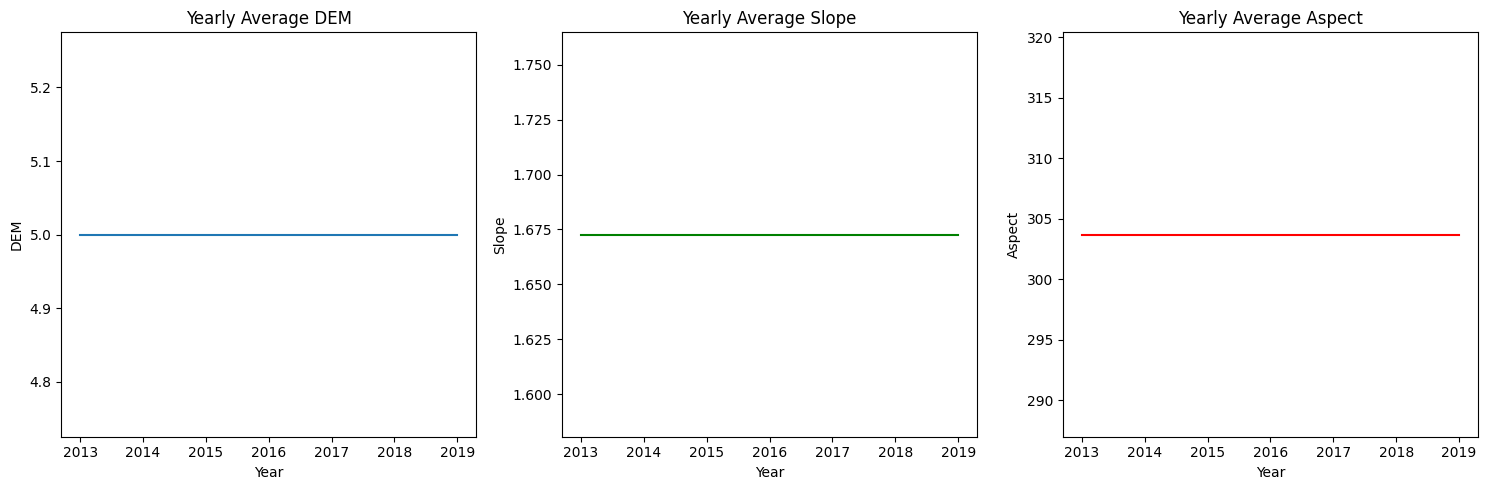

In [ ]:
# Double Check: Static features remain constant?

# Flooded
f_lat = 24.351155
f_lon = 91.113749
tolerance = 0.0001  # Define a small tolerance range

selected_data = train[(train['latitude'].between(f_lat - tolerance, f_lat + tolerance)) &
                      (train['longitude'].between(f_lon - tolerance, f_lon + tolerance))]

yearly_daily_DEM = selected_data.groupby(['YEAR', 'DOY'])['DEM'].mean()
yearly_daily_Slope = selected_data.groupby(['YEAR', 'DOY'])['Slope'].mean()
yearly_daily_Aspect = selected_data.groupby(['YEAR', 'DOY'])['Aspect'].mean()

# Group by Year and calculate the mean for each feature
yearly_stats_DEM = yearly_daily_DEM.groupby(['YEAR']).mean()
yearly_stats_Slope = yearly_daily_Slope.groupby(['YEAR']).mean()
yearly_stats_Aspect = yearly_daily_Aspect.groupby(['YEAR']).mean()

# Plotting
plt.figure(figsize=(15, 5))

# DEM Plot
plt.subplot(1, 3, 1)
yearly_stats_DEM.plot(kind='line', title='Yearly Average DEM')
plt.xlabel('Year')
plt.ylabel('DEM')

# Slope Plot
plt.subplot(1, 3, 2)
yearly_stats_Slope.plot(kind='line', color='green', title='Yearly Average Slope')
plt.xlabel('Year')
plt.ylabel('Slope')

# Aspect Plot
plt.subplot(1, 3, 3)
yearly_stats_Aspect.plot(kind='line', color='red', title='Yearly Average Aspect')
plt.xlabel('Year')
plt.ylabel('Aspect')

plt.tight_layout()
plt.show()

In [ ]:
print("Is DEM constant over time yearly? ", np.isclose(yearly_stats_DEM, 5.0).all())
print("Is DEM constant over time daily? ", np.isclose(yearly_daily_DEM, 5.0).all())
print("Is Slope constant over time yearly? ", np.isclose(yearly_stats_Slope, 1.672712).all())
print("Is Slope constant over time daily? ", np.isclose(yearly_daily_Slope, 1.672712).all())
print("Is Aspect constant over time yearly? ",  np.isclose(yearly_stats_Aspect, 303.690063).all())
print("Is Aspect constant over time daily? ",  np.isclose(yearly_daily_Aspect, 303.690063).all())

Is DEM constant over time yearly?  True
Is DEM constant over time daily?  True
Is Slope constant over time yearly?  True
Is Slope constant over time daily?  True
Is Aspect constant over time yearly?  True
Is Aspect constant over time daily?  True


## Exploring topological features

**Observations  & Conclusion:**

1. Elevation DEM: Lower elevation areas area more prone to flooding.
2. Slope: Flat areas (lower slope values) are more prone to flooding. Nevertheless, very high slope (max value) might indicate areas where water run-off contributes to flooding.
3. Aspect: Notable difference in average value of the slope direction in flood & non-flood locations.
4. The map shows that flooded & non-flooded locations are separable.

**Question:**
1. Negative DEM outlier? (Likely Nature of the dataset)
2. Max slope outlier? (Likely Nature of the dataset)

In [ ]:
# Exploring the relationship between the target & topographical features
stats = train.groupby('Flood/No Flood')[['DEM', 'Slope', 'Aspect']].describe()
stats.transpose()

Flood/No Flood              F              N
DEM    count    654336.000000  654336.000000
       mean          6.160156      13.015625
       std           3.041662       6.624987
       min          -1.000000       1.000000
       25%           5.000000       8.000000
       50%           6.000000      12.000000
       75%           8.000000      17.000000
       max          15.000000      41.000000
Slope  count    654336.000000  654336.000000
       mean          1.386635       1.857107
       std           1.433676       1.156455
       min           0.000000       0.000000
       25%           0.608199       0.984320
       50%           1.182954       1.640247
       75%           1.696165       2.576675
       max          12.797206       6.167385
Aspect count    654336.000000  654336.000000
       mean        142.841631     177.979039
       std         112.884524     104.580090
       min           0.000000       0.000000
       25%          29.864080      97.682627
       50%         135.000000     177.402786
       75%         240.135918     270.000000
       max         355.601288     356.633545

**Flooded areas seem to be separable**

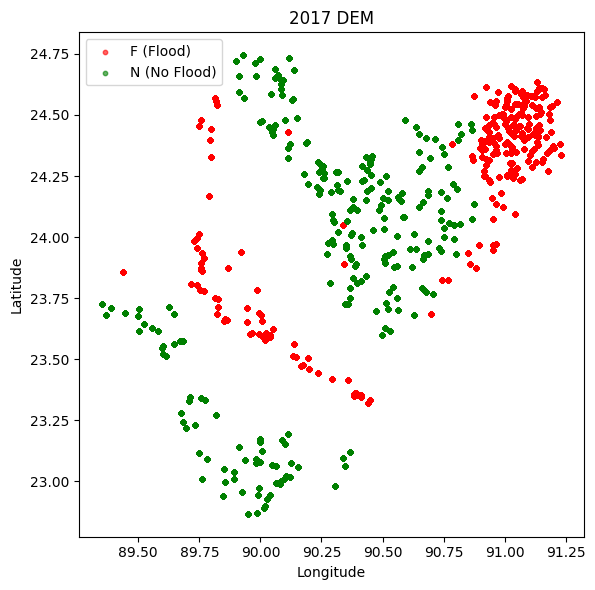

In [ ]:
# Filter one year: 2017
selected_year = 2017
train_2017 = train[train['YEAR'] == selected_year]
gdf = gpd.GeoDataFrame(train_2017, geometry=gpd.points_from_xy(train_2017.longitude, train_2017.latitude))

# Define color map for Flood/No-Flood
color_map = {'F': 'red', 'N': 'green'}
gdf['color'] = gdf['Flood/No Flood'].map(color_map)

plt.figure(figsize=(10, 6))
for key, group in gdf.groupby('Flood/No Flood'):
    color = color_map[key]
    label = f"{key} ({'Flood' if key == 'F' else 'No Flood'})"
    group.plot(ax=plt.gca(), color=color, label=label, markersize=10, alpha=0.6)

plt.title(f"{selected_year} DEM")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.show()

**Correlations to Flood**

* Topographical Features (epseically DEM) are significant predictors of flood
(strong negative correlation).

In [ ]:
corr_matrix = train.corr(numeric_only=True)

In [ ]:
corr_matrix['Flood'].sort_values(ascending=False)

Flood          1.000000e+00
longitude      4.817239e-01
latitude       3.378601e-01
GWETTOP        6.572382e-02
PRECTOTCORR    5.448835e-02
GWETROOT       5.281522e-02
GWETPROF       4.331412e-02
RH2M           4.063385e-02
PS             1.744489e-02
QV2M           1.249248e-02
WS2M_RANGE     1.623964e-03
DOY           -2.698577e-15
YEAR          -1.619923e-14
T2M_RANGE     -1.139430e-02
T2M_MIN       -1.530462e-02
T2M           -1.853927e-02
T2M_MAX       -3.514989e-02
WS2M_MAX      -5.664266e-02
WS2M          -8.080531e-02
WD2M          -9.501995e-02
WS2M_MIN      -9.796849e-02
Aspect        -1.593957e-01
Slope         -1.777332e-01
DEM           -5.537225e-01
Name: Flood, dtype: float64

## Weather-Related Features Exploration

**Observations and Conclusion**

1. The number of floods is the same across different seasons (**Surprising**)
2. Weather features show seasonal pattern over year.

In [ ]:
# Define the seasons based on DOY
def label_season(doy):
    if doy in range(335, 366) or doy in range(1, 60):
        return 'Dry Season'
    elif doy in range(60, 152):
        return 'Pre-Monsoon'
    elif doy in range(152, 244):
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

In [ ]:
# Create season column
train['Season'] = train['DOY'].apply(label_season)

<ipython-input-16-6d3996f118e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Season'] = train['DOY'].apply(label_season)


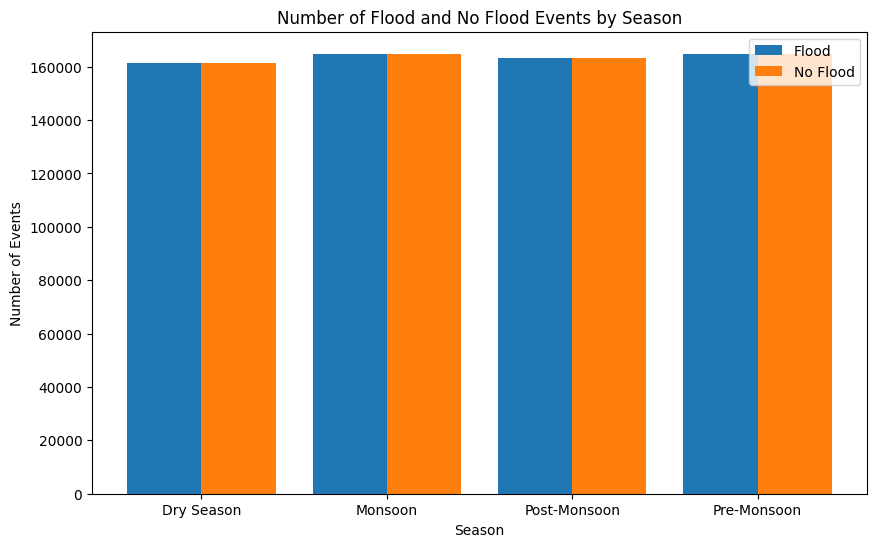

In [ ]:
# Plot the distribution of flood events by season
seasonal_counts = train.groupby(['Season', 'Flood']).size().unstack()

# Plotting a grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Set the positions and width for the bars
positions = range(len(seasonal_counts))
width = 0.4

# Plotting bars for 'Flood' and 'No Flood' side by side
ax.bar(positions, seasonal_counts[1], width=width, label='Flood', align='center')
ax.bar([p + width for p in positions], seasonal_counts[0], width=width, label='No Flood', align='center')

# Setting the position of x ticks to be in the middle of the grouped bars
ax.set_xticks([p + width / 2 for p in positions])
ax.set_xticklabels(seasonal_counts.index)

# Adding the legend and labels
ax.legend()
ax.set_title('Number of Flood and No Flood Events by Season')
ax.set_xlabel('Season')
ax.set_ylabel('Number of Events')

plt.show()

In [ ]:
train.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'WS2M', 'PS', 'WS2M_MAX', 'WS2M_MIN', 'WS2M_RANGE',
       'WD2M', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude', 'longitude',
       'DEM', 'Slope', 'Aspect', 'Flood/No Flood', 'Flood', 'Season'],
      dtype='object')

In [ ]:
static_features = ['latitude', 'longitude', 'DEM', 'Slope', 'Aspect']
dynamic_features = ['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'WS2M', 'PS', 'WS2M_MAX', 'WS2M_MIN', 'WS2M_RANGE',
       'WD2M', 'GWETTOP', 'GWETROOT', 'GWETPROF','Season']

In [ ]:
weather_features = ['T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'WS2M', 'PS', 'WS2M_MAX', 'WS2M_MIN', 'WS2M_RANGE',
       'WD2M', 'GWETTOP', 'GWETROOT', 'GWETPROF']

In [ ]:
# Separate flood & non-flood records
flood_days = train[train['Flood']== 1]
no_flood_days = train[train['Flood']== 0]

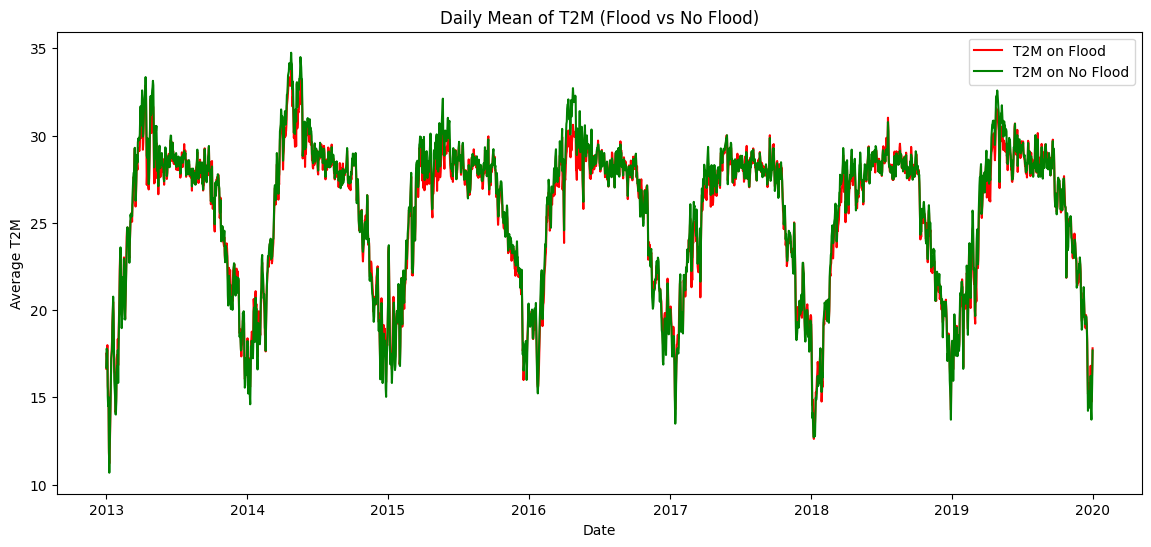

----------------------------------------------------------------------------------------------------------------------------------------------------------------


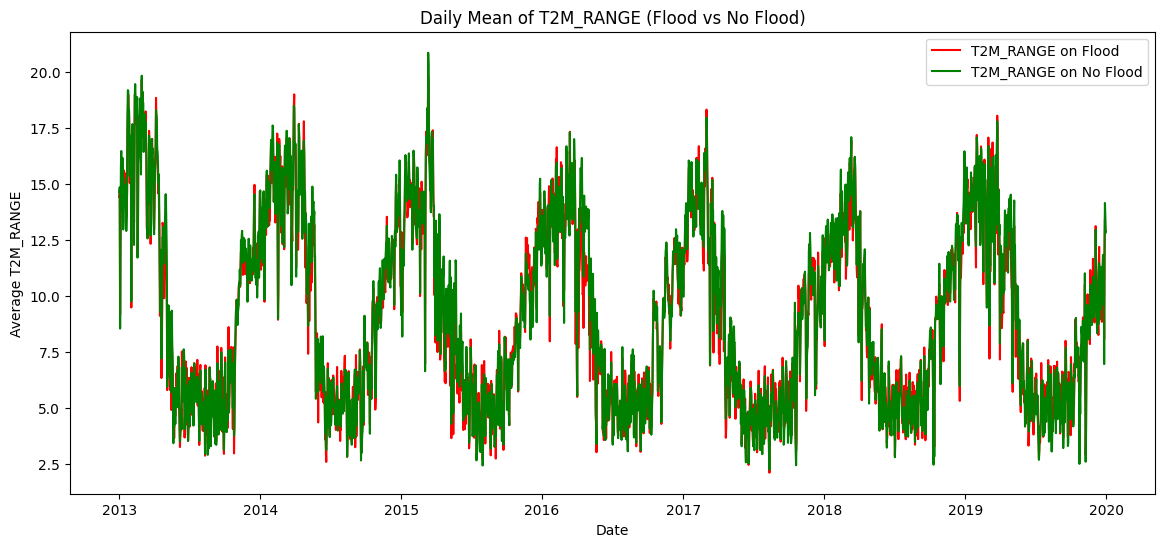

----------------------------------------------------------------------------------------------------------------------------------------------------------------


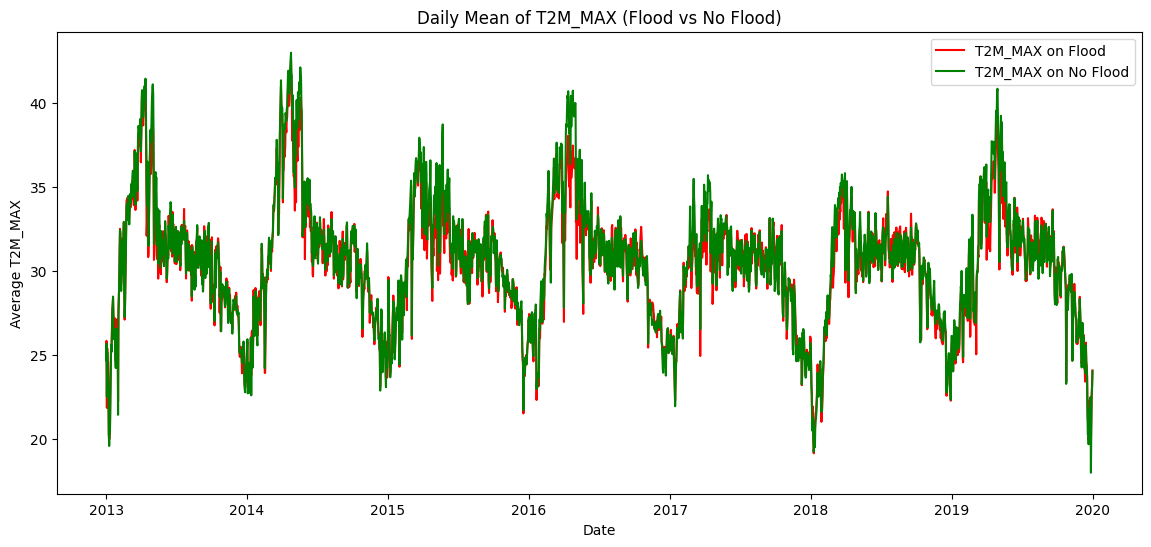

----------------------------------------------------------------------------------------------------------------------------------------------------------------


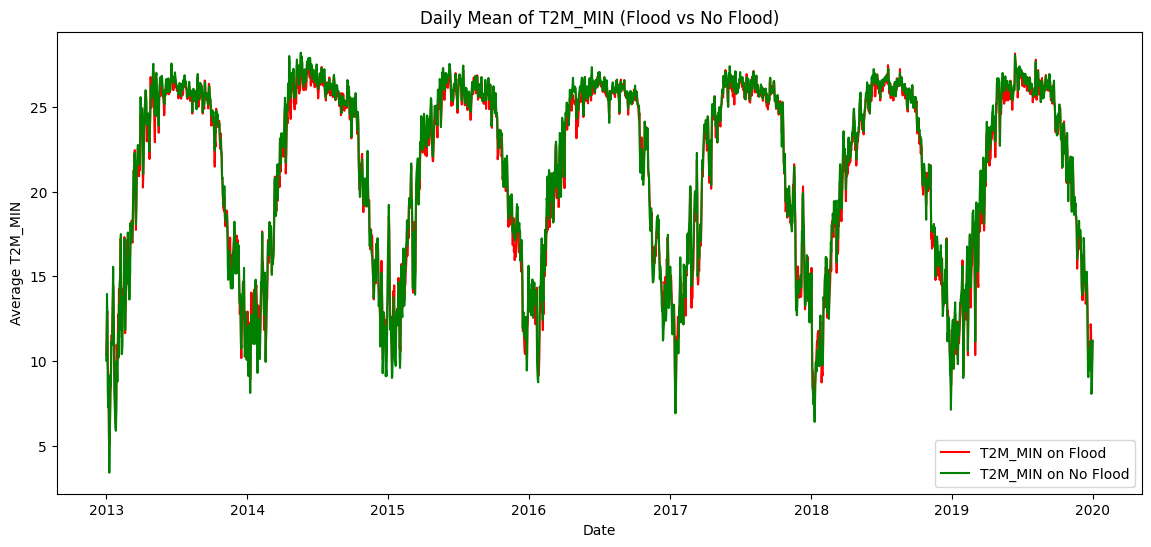

----------------------------------------------------------------------------------------------------------------------------------------------------------------


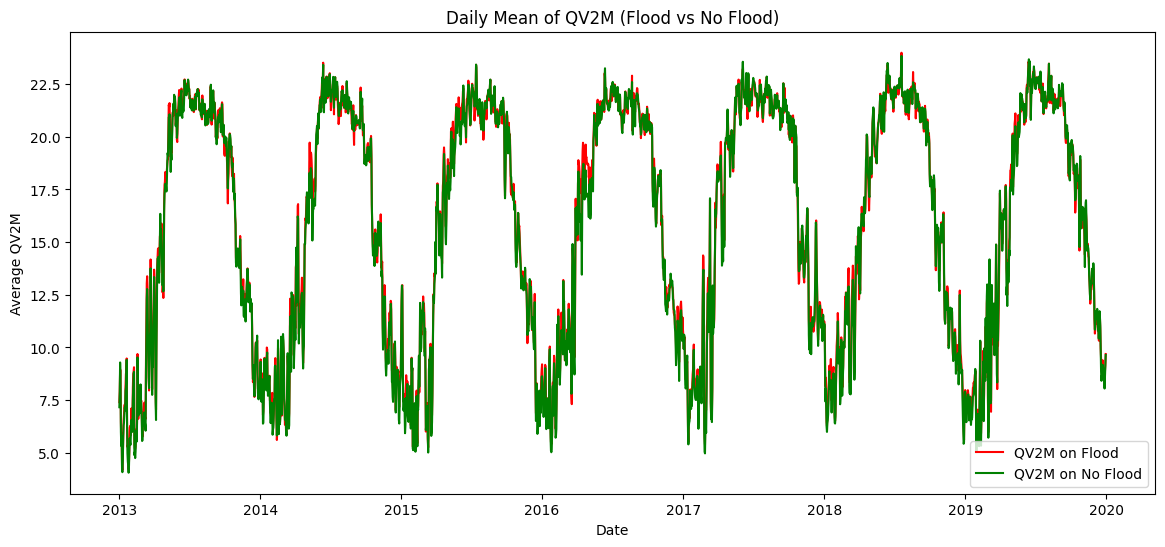

----------------------------------------------------------------------------------------------------------------------------------------------------------------


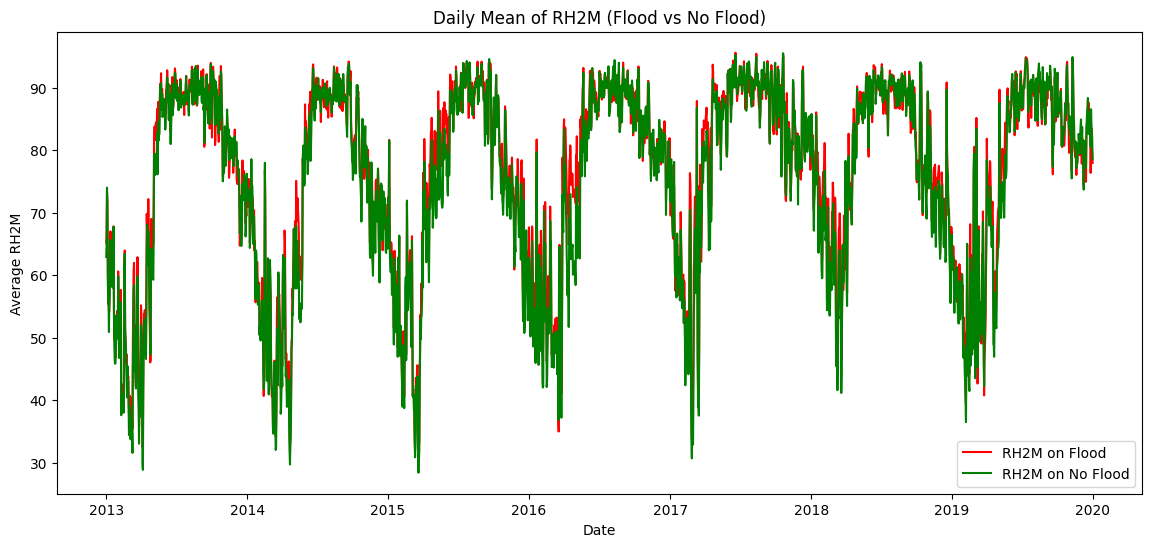

----------------------------------------------------------------------------------------------------------------------------------------------------------------


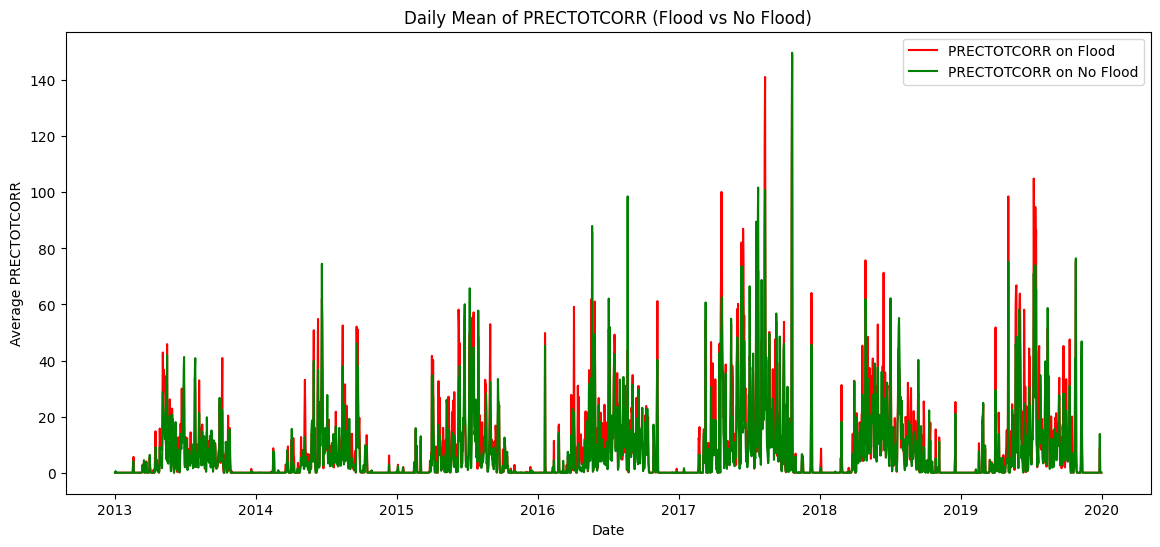

----------------------------------------------------------------------------------------------------------------------------------------------------------------


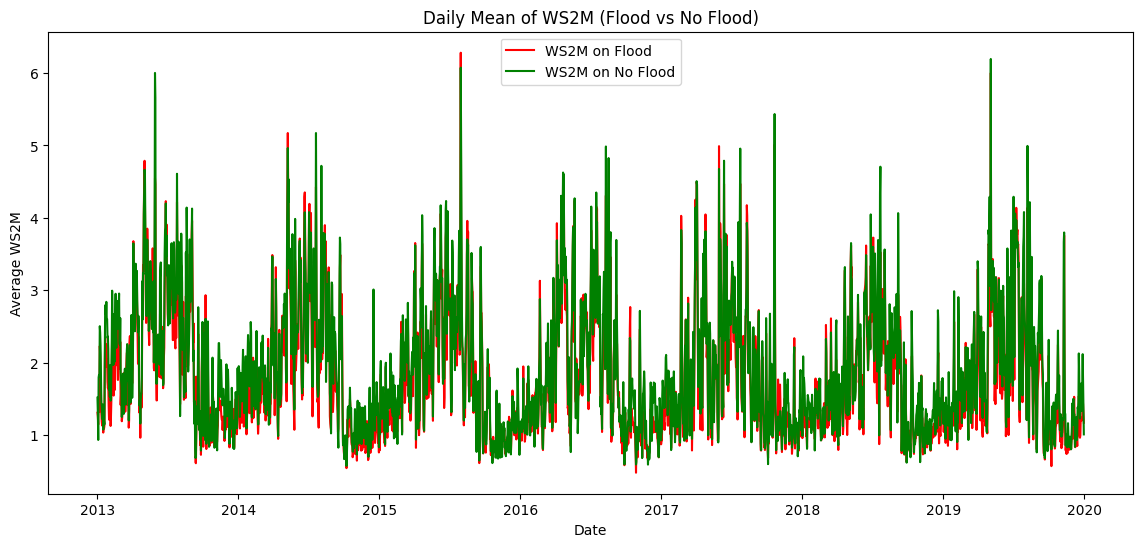

----------------------------------------------------------------------------------------------------------------------------------------------------------------


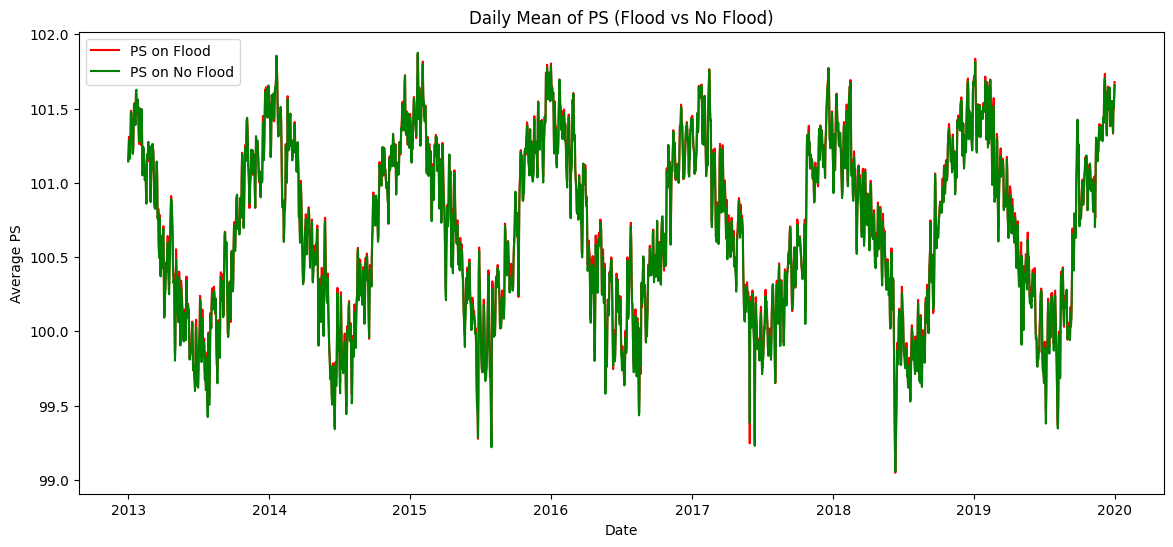

----------------------------------------------------------------------------------------------------------------------------------------------------------------


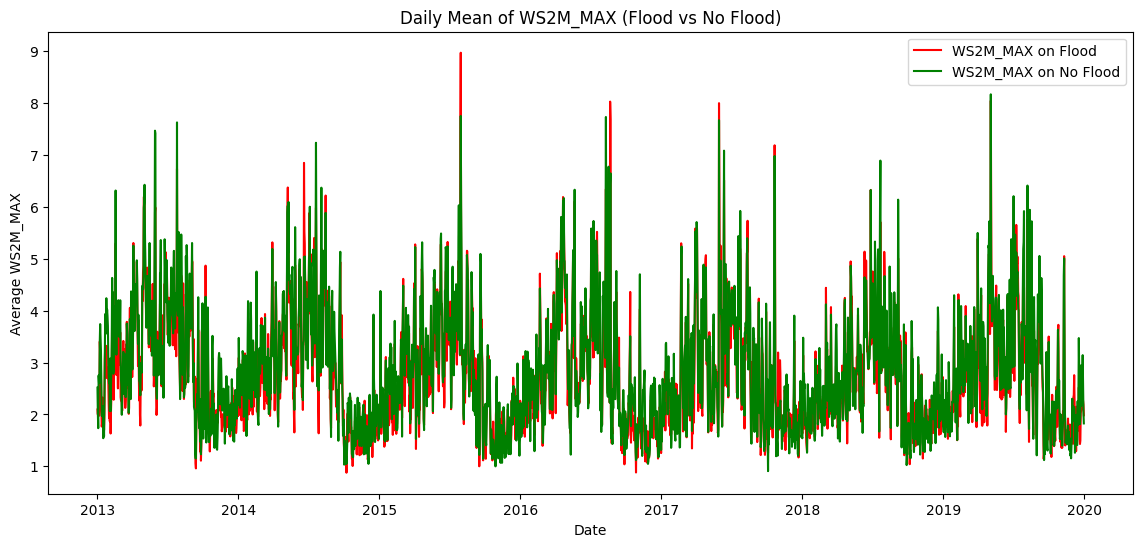

----------------------------------------------------------------------------------------------------------------------------------------------------------------


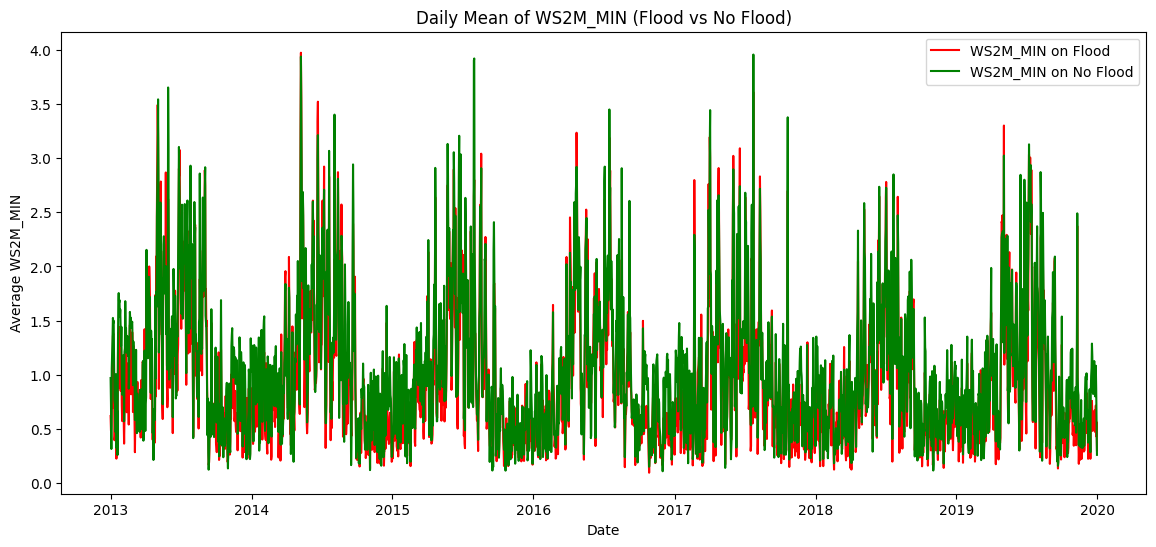

----------------------------------------------------------------------------------------------------------------------------------------------------------------


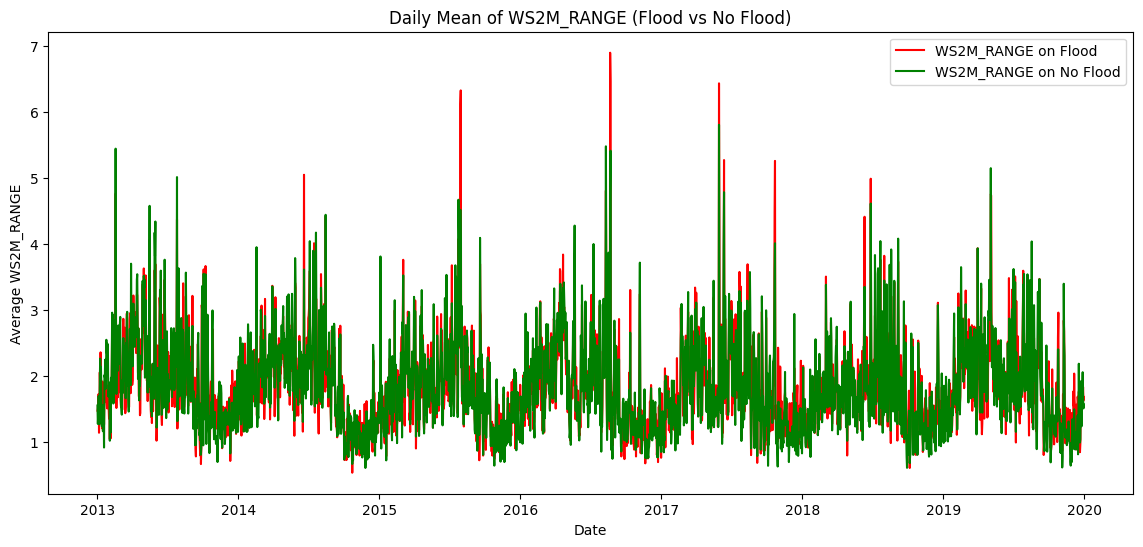

----------------------------------------------------------------------------------------------------------------------------------------------------------------


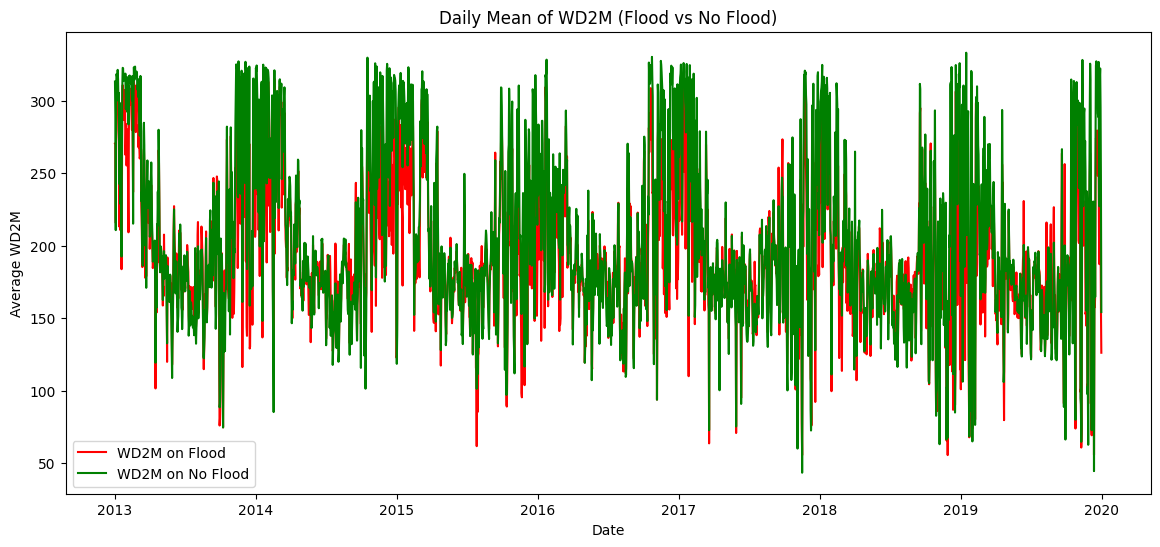

----------------------------------------------------------------------------------------------------------------------------------------------------------------


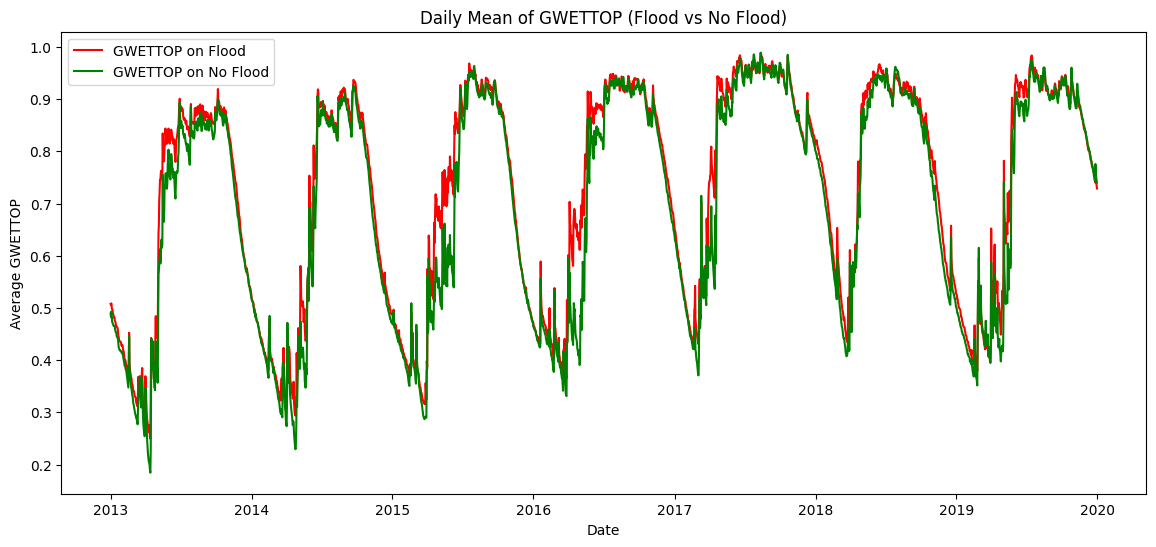

----------------------------------------------------------------------------------------------------------------------------------------------------------------


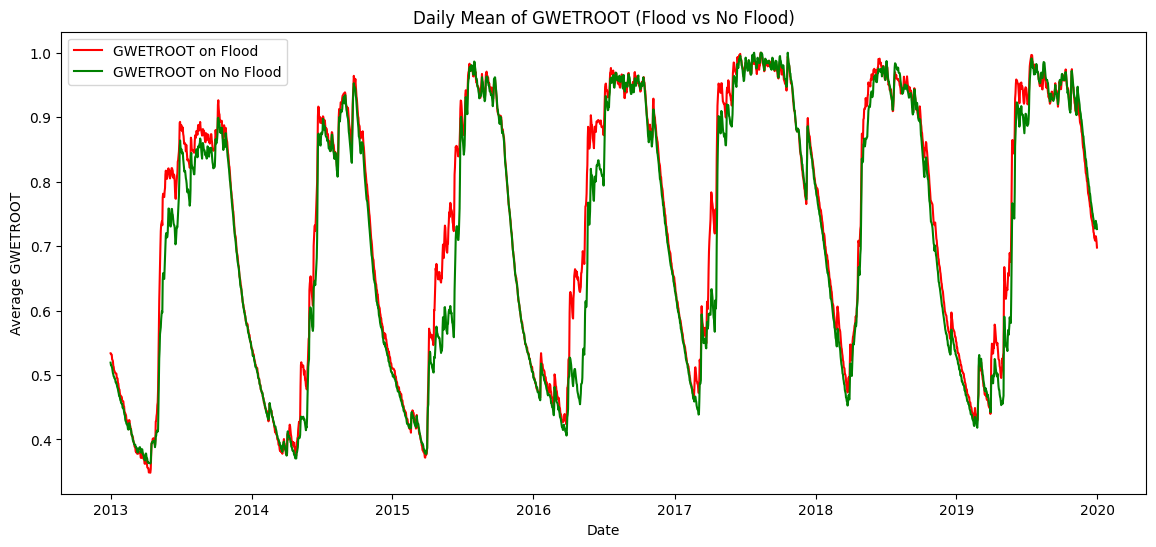

----------------------------------------------------------------------------------------------------------------------------------------------------------------


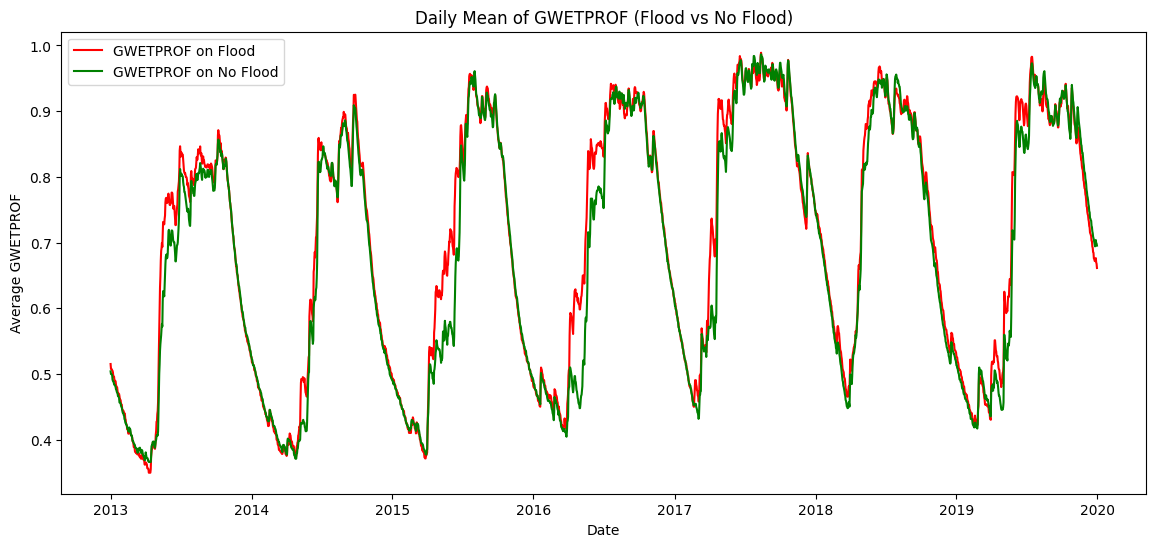

----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
for feature in weather_features:
    # Daily mean for flood days across all locations
    flood_day_grp = flood_days.groupby('Date')[feature]
    flood_days_avg = flood_day_grp.mean()

    # Daily mean for non-flood days across all locations
    no_flood_day_grp = no_flood_days.groupby('Date')[feature]
    no_flood_days_avg = no_flood_day_grp.mean()

    # Create the plots on the same chart for comparison
    plt.figure(figsize=(14, 6))

    plt.plot(flood_days_avg.index, flood_days_avg.values, label=f'{feature} on Flood', color='red')
    plt.plot(no_flood_days_avg.index, no_flood_days_avg.values, label=f'{feature} on No Flood', color='green')

    plt.title(f'Daily Mean of {feature} (Flood vs No Flood)')
    plt.xlabel('Date')
    plt.ylabel(f'Average {feature}')
    plt.legend()
    plt.show()
    print("-"*160)

### Exploring Weather in Monsoon for 2017

**Observations and Conclusion**

1. Once the precipitation level crosses around 28 meter in a day, there is a higher chance of flood.
2. There is much higher probability of having flood when wind speed is in 1-2 m/s range.
3. Once the soil becomes very saturated, there is also a much higher chance of flood.

In [ ]:
# Filter the dataset
monsoon = train[(train['Season'] == 'Monsoon') & (train['YEAR'] == 2017)]

In [ ]:
def pdf(monsoon, feature, unit, subtitle):
  # Plot distribution as kernel density estimate
  sns.displot(monsoon, x=feature, hue="Flood", kind="kde", fill=True, palette=["red", "blue"])

  # Compute mean
  flood_mean = monsoon.loc[monsoon['Flood'] == 1, feature].mean()
  no_flood_mean = monsoon.loc[monsoon['Flood'] == 0, feature].mean()

  # Add text annotation
  plt.figtext(0.8, 0.8, "Flood mean: {:.2f}".format(flood_mean))
  plt.figtext(0.8, 0.7, "No flood mean: {:.2f}".format(no_flood_mean))

  # Adjust subplot params to make space for text
  plt.subplots_adjust(right=0.75)

  plt.xlabel(f"{feature} {unit}")
  plt.ylabel('Density')
  plt.title(f'Distribution of {subtitle} by Flood Occurence')

  plt.show()

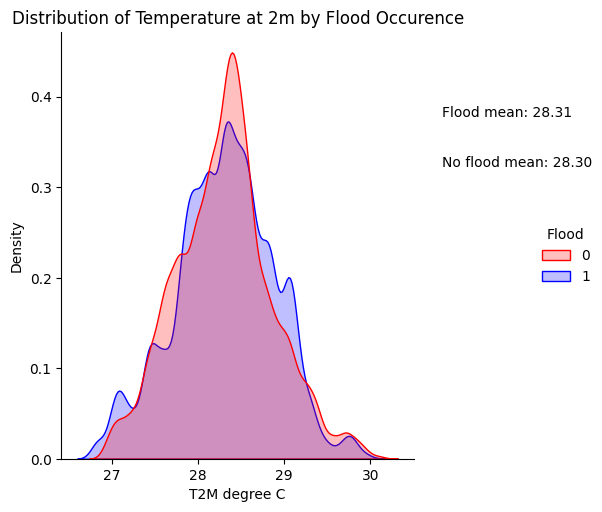

In [ ]:
pdf(monsoon, "T2M", "degree C", "Temperature at 2m")

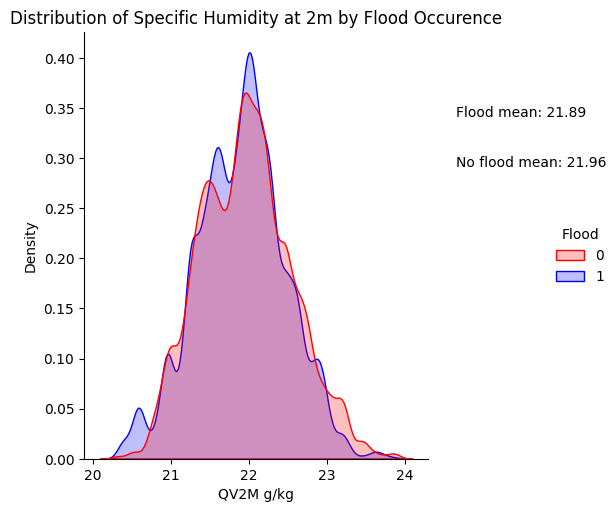

In [ ]:
pdf(monsoon, "QV2M", "g/kg", "Specific Humidity at 2m")

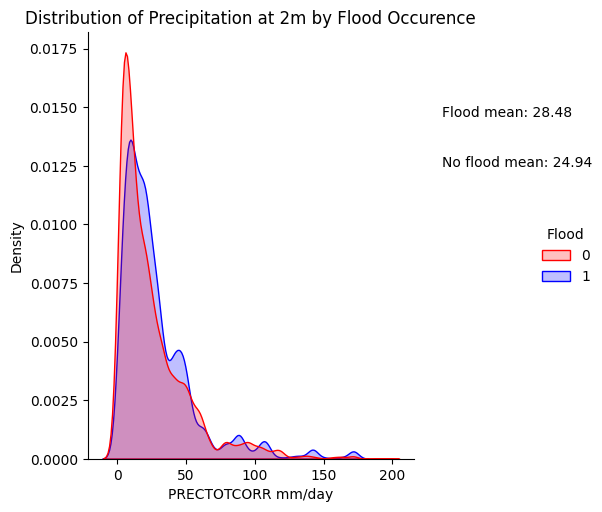

In [ ]:
# There seems to be higher chance of flood once the preciptation crosses certain
# threshold (around 28 mm of rain)
pdf(monsoon, "PRECTOTCORR", "mm/day", "Precipitation at 2m")

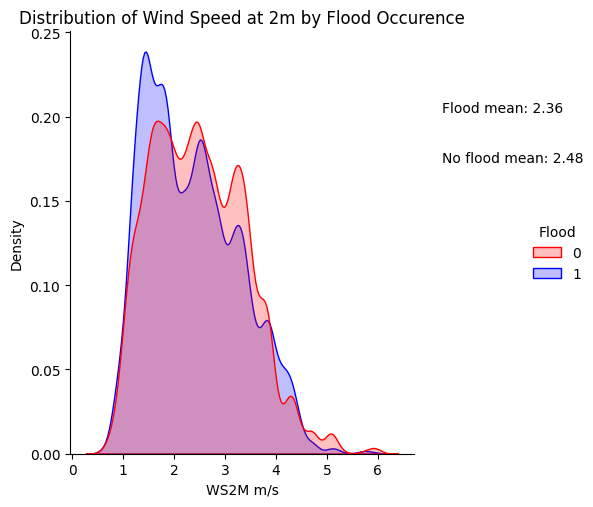

In [ ]:
# Much higher probability of having flood when wind speed is in 1-2 m/s range
pdf(monsoon, "WS2M", "m/s", "Wind Speed at 2m")

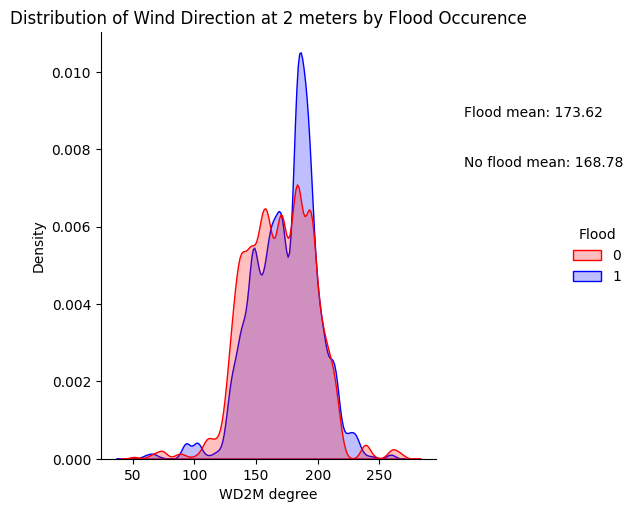

In [ ]:
# WD2M: Wind Direction at 2 Meters (Degrees) - Average wind direction at 2 meters above the ground.
pdf(monsoon, "WD2M", "degree", "Wind Direction at 2 meters")

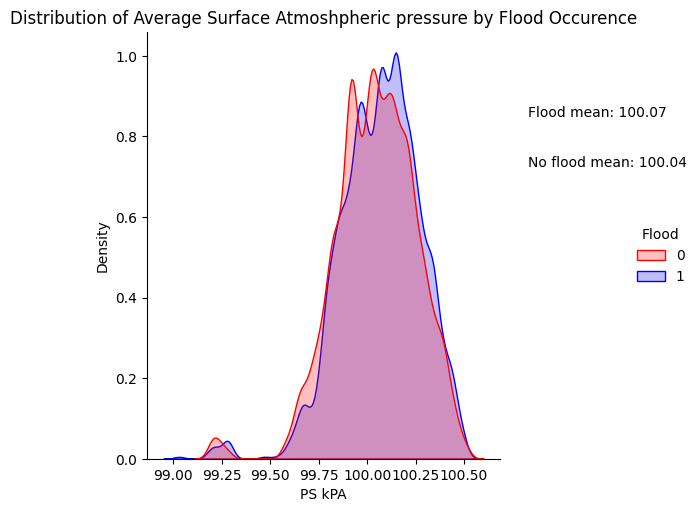

In [ ]:
# PS: Surface Pressure (kPa) - Average surface atmospheric pressure.
pdf(monsoon, "PS", "kPA", "Average Surface Atmoshpheric pressure")

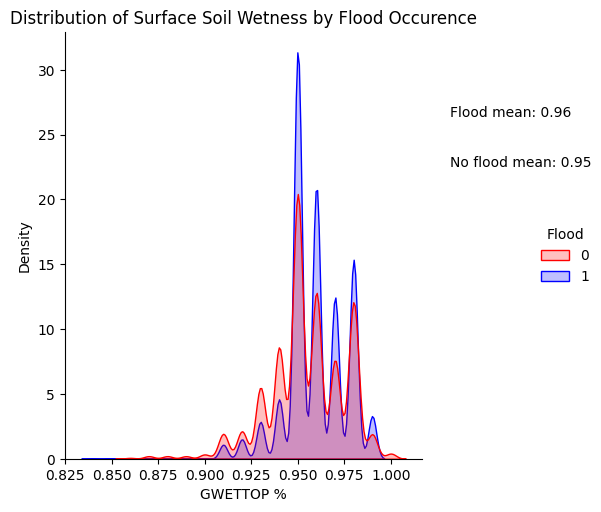

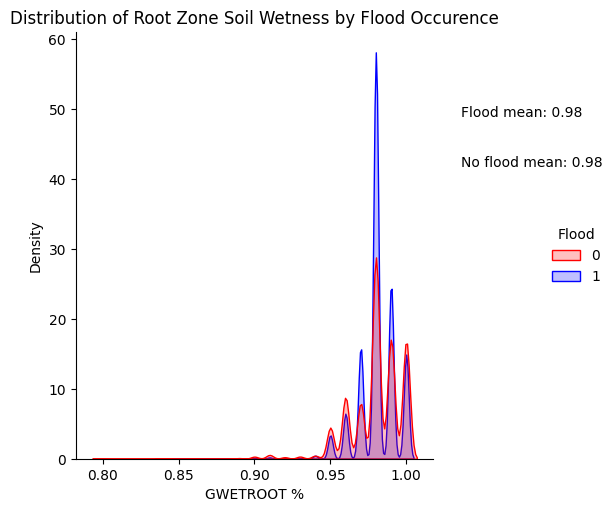

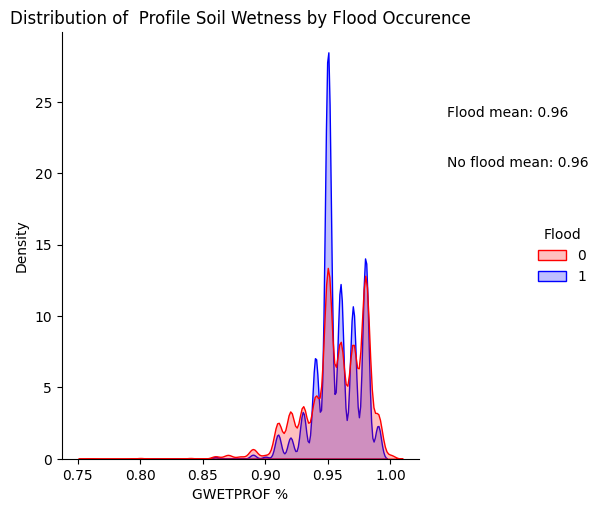

In [ ]:
# Once the soil gets very saturated there is a higher chance of flood.
pdf(monsoon, "GWETTOP", "%", "Surface Soil Wetness")
pdf(monsoon, "GWETROOT", "%", "Root Zone Soil Wetness")
pdf(monsoon, "GWETPROF", "%", " Profile Soil Wetness")

# Feature Engineering

**Wind: Convert Wind Speed & Direction into Wind Vector with x and y components**

Text(0, 0.5, 'Wind Speet at 2 meter m/s')

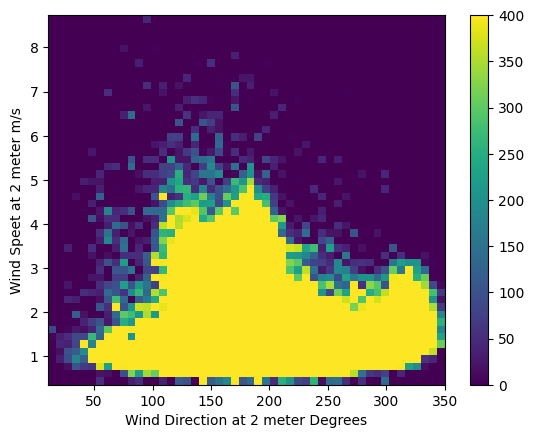

In [ ]:
plt.hist2d(df['WD2M'], df['WS2M'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel("Wind Direction at 2 meter Degrees")
plt.ylabel("Wind Speet at 2 meter m/s")

Text(0, 0.5, 'Wind Speet at 2 meter m/s')

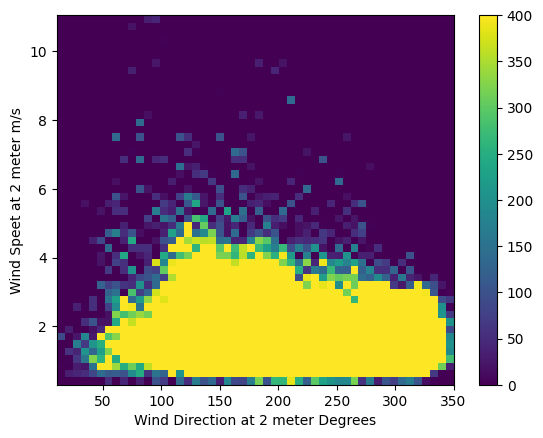

In [ ]:
plt.hist2d(df['WD2M'], df['WS2M_RANGE'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel("Wind Direction at 2 meter Degrees")
plt.ylabel("Wind Speet at 2 meter m/s")

In [ ]:
def calculate_wind_components(ws, wd):
    # Convert wind direction in degrees to radians
    wd_rad = wd * np.pi / 180

    # Compute x- and y-components of wind vector
    wx = ws * np.cos(wd_rad)
    wy = ws * np.sin(wd_rad)

    return wx, wy

In [ ]:
# WS2M: Wind Speed at 2 Meters (m/s) - Average wind speed at 2 meters above the ground. (Dynamic Feature)
# WS2M_MAX: Wind Speed at 2 Meters Maximum (m/s) - Maximum hourly wind speed at 2 meters. (Dynamic Feature)
# WS2M_MIN: Wind Speed at 2 Meters Minimum (m/s) - Minimum hourly wind speed at 2 meters. (Dynamic Feature)
# WS2M_RANGE: Wind Speed at 2 Meters Range (m/s) - Range of minimum and maximum hourly wind speed at 2 meters. (Dynamic Feature)
# WD2M: Wind Direction at 2 Meters (Degrees) - Average wind direction at 2 meters above the ground. (Dynamic Feature)
ws2m = df.pop(item='WS2M')
ws2m_max = df.pop(item='WS2M_MAX')
ws2m_min = df.pop(item='WS2M_MIN')
ws2m_range = df.pop(item='WS2M_RANGE')
wd2m = df.pop(item='WD2M')

# Calculate wind x and y components
wx, wy = calculate_wind_components(ws2m, wd2m)
df['ws2m_x'] = wx
df['ws2m_y'] = wy

wx, wy = calculate_wind_components(ws2m_max, wd2m)
df['ws2m_max_x'] = wx
df['ws2m_max_y'] = wy

wx, wy = calculate_wind_components(ws2m_min, wd2m)
df['ws2m_min_x'] = wx
df['ws2m_min_y'] = wy

wx, wy = calculate_wind_components(ws2m_range, wd2m)
df['ws2m_range_x'] = wx
df['ws2m_range_y'] = wy

In [ ]:
df.head()

YEAR  DOY    T2M  T2M_RANGE  T2M_MAX  T2M_MIN  QV2M   RH2M  \
Date                                                                     
2013-01-01  2013    1  16.55      14.43    24.88    10.45  7.57  67.00   
2013-01-01  2013    1  16.55      14.43    24.88    10.45  7.57  67.00   
2013-01-01  2013    1  16.55      14.43    24.88    10.45  7.57  67.00   
2013-01-01  2013    1  17.13      13.39    24.43    11.04  7.39  62.94   
2013-01-01  2013    1  15.87      14.62    23.77     9.15  7.26  66.75   

            PRECTOTCORR      PS  ...  Flood/No Flood  Flood    ws2m_x  \
Date                             ...                                    
2013-01-01          0.0  101.17  ...               F      1 -0.594504   
2013-01-01          0.0  101.17  ...               F      1 -0.594504   
2013-01-01          0.0  101.17  ...               F      1 -0.594504   
2013-01-01          0.0  101.18  ...               F      1 -0.328429   
2013-01-01          0.0  101.07  ...               F      1  1.280714   

              ws2m_y  ws2m_max_x  ws2m_max_y  ws2m_min_x  ws2m_min_y  \
Date                                                                   
2013-01-01 -0.949192   -0.902372   -1.440738   -0.180474   -0.288148   
2013-01-01 -0.949192   -0.902372   -1.440738   -0.180474   -0.288148   
2013-01-01 -0.949192   -0.902372   -1.440738   -0.180474   -0.288148   
2013-01-01 -1.422580   -0.553380   -2.396950   -0.193458   -0.837958   
2013-01-01 -1.133080    2.149503   -1.901720    0.943684   -0.834901   

           ws2m_range_x  ws2m_range_y  
Date                                   
2013-01-01    -0.716590     -1.144115  
2013-01-01    -0.716590     -1.144115  
2013-01-01    -0.716590     -1.144115  
2013-01-01    -0.359922     -1.558992  
2013-01-01     1.205819     -1.066818  

[5 rows x 28 columns]

(-7.735385268862389, 3.8928053604376793, -6.875953665560713, 8.71543621757465)

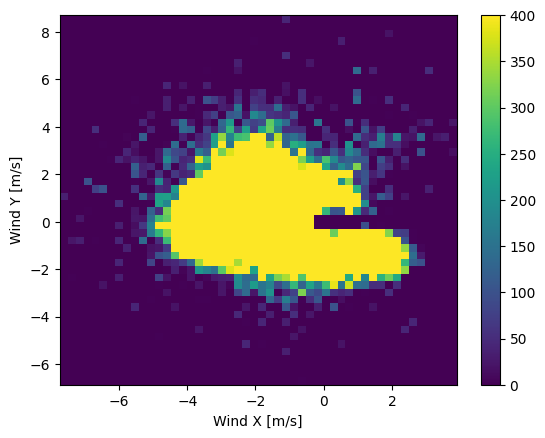

In [ ]:
# Easier to differentiate by the model
plt.hist2d(df['ws2m_x'], df['ws2m_y'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel("Wind X [m/s]")
plt.ylabel("Wind Y [m/s]")
ax = plt.gca()
ax.axis('tight')

**Time: Given the cyclic nature of the day of the year column, transform using sine & cosine.**

In [ ]:
# Calculate the sine and cosine transformations on DOY column
# to capture it's cyclical nature
df['sin_DOY'] = np.sin(2 * np.pi * df['DOY'] / 365)
df['cos_DOY'] = np.cos(2 * np.pi * df['DOY'] / 365)

Text(0.5, 1.0, 'Time of day signal')

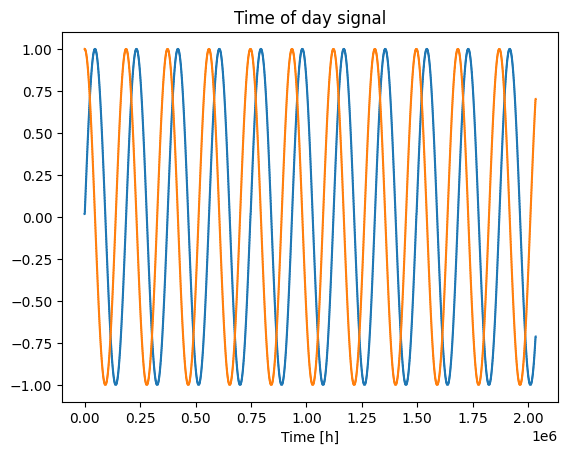

In [ ]:
plt.plot(np.array(df['sin_DOY']))
plt.plot(np.array(df['cos_DOY']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

**Precipitation:**

Looking at Precipitation distribution on flood & no-flood days, it seems that there is a higher average precipitation on flooded-days.

Therefore, this new (lag) feature sum the total precipitation over a short window before the current day.

In [ ]:
window_size = 3
# Shifting is important to prevent the current day's rainfall itself
# Calculate the rolling sum of the past 3 days of precipitation, not including the current day
df['precip_sum'] = df['PRECTOTCORR'].rolling(window=window_size, min_periods=1).sum().shift(1)

In [ ]:
df[['PRECTOTCORR', 'precip_sum']].head()

PRECTOTCORR  precip_sum
Date                               
2013-01-01          0.0         NaN
2013-01-01          0.0         0.0
2013-01-01          0.0         0.0
2013-01-01          0.0         0.0
2013-01-01          0.0         0.0

In [ ]:
# Make sense to fill the first value with 0
df['precip_sum'] = df['precip_sum'].fillna(0)

**Soil**

Changes in soil saturation over time might be a good indicator of flood since the soil saturation reaching a certain % increase the odd of flood.

Therefore, these new (lag) featrues calculate the changes in soil saturation level over past few days.

In [ ]:
soil_window_size = 3

# Calculate the rolling change average for each soil wetness feature
df['GWETTOP_rolling_change'] = df['GWETTOP'].diff().rolling(window=soil_window_size).mean().shift(1)
df['GWETROOT_rolling_change'] = df['GWETROOT'].diff().rolling(window=soil_window_size).mean().shift(1)
df['GWETPROF_rolling_change'] = df['GWETPROF'].diff().rolling(window=soil_window_size).mean().shift(1)

# Fill the NaN with 0
df['GWETTOP_rolling_change'] = df['GWETTOP_rolling_change'].fillna(0)
df['GWETROOT_rolling_change'] = df['GWETROOT_rolling_change'].fillna(0)
df['GWETPROF_rolling_change'] = df['GWETPROF_rolling_change'].fillna(0)


In [ ]:
soil_window_size = 3

# Calculate the rolling change average for each soil wetness feature
df['GWETTOP_rolling_change'] = df['GWETTOP'].diff().rolling(window=soil_window_size).mean().shift(1)
df['GWETROOT_rolling_change'] = df['GWETROOT'].diff().rolling(window=soil_window_size).mean().shift(1)
df['GWETPROF_rolling_change'] = df['GWETPROF'].diff().rolling(window=soil_window_size).mean().shift(1)


In [ ]:
# Fill the NaN with 0
df['GWETTOP_rolling_change'] = df['GWETTOP_rolling_change'].fillna(0)
df['GWETROOT_rolling_change'] = df['GWETROOT_rolling_change'].fillna(0)
df['GWETPROF_rolling_change'] = df['GWETPROF_rolling_change'].fillna(0)

In [ ]:
# Drop this uncessary column
df.drop(columns='Flood/No Flood', inplace=True)

In [ ]:
df.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
# Save df to csv in current directory
df.to_csv('/content/drive/MyDrive/GIS Data Analysis/processed_data.csv')

In [ ]:
# Read from the csv file into pandas dataframe
df_p = pd.read_csv('/content/drive/MyDrive/GIS Data Analysis/processed_data.csv', index_col=0)

In [ ]:
df_p.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
# Drop unecessary columns Needed later for sorting
# df_p.drop(columns=['DOY'], inplace=True)

In [ ]:
df_p.columns

Index(['YEAR', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

# Modeling Approaches:

1. Spatial & Environmental Condition Model

2. Time-Series Based Model

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix for {model_name}', size = 15)

# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

## 1) Spatial & Environmental Condition Model

In [ ]:
# Select features relevant for spatial & weather-realted conditions
sp_env_feature = ['T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y']
label = ['Flood']

In [ ]:
sp_env_df = df_p[sp_env_feature + label]

**Split the data based on locations:**

The same location can't be both in train & test set (80-20 split).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create a unique identifier for each location
sp_env_df['location_id'] = sp_env_df['latitude'].astype(str) + '_' + sp_env_df['longitude'].astype(str)

# Split the unique locations into training and test sets
unique_locations = sp_env_df['location_id'].unique()

train_locations, test_locations = train_test_split(unique_locations,
                                                   test_size=0.2,
                                                   random_state=42)

# Split the DataFrame based on the locations
train_df = sp_env_df[sp_env_df['location_id'].isin(train_locations)]
test_df = sp_env_df[sp_env_df['location_id'].isin(test_locations)]

# Drop the 'location_id' as it's no longer needed for modeling
train_df = train_df.drop('location_id', axis=1)
test_df = test_df.drop('location_id', axis=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(1624139, 25)
(409013, 25)


In [ ]:
spenv_X_train, spenv_Y_train = train_df[sp_env_feature], train_df[label]
spenv_X_test, spenv_Y_test = test_df[sp_env_feature], test_df[label]

In [ ]:
print(spenv_X_train.shape)
print(spenv_Y_train.shape)
print(spenv_X_test.shape)
print(spenv_Y_test.shape)

(1624139, 24)
(1624139, 1)
(409013, 24)
(409013, 1)


**Tree-based model:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, cohen_kappa_score, precision_recall_curve, roc_curve, auc

In [ ]:
# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name,
                         thresholds):
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    print("Training...")
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate at each threshold
    for threshold in thresholds:
        # Apply threshold to positive class probabilities to create new predictions
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)

        # Print classification metrics
        print(f"Classification Report for {model_name} at threshold {threshold}:")
        print(classification_report(y_test, y_pred_threshold))

        # Cohen Kappa Score
        kappa = cohen_kappa_score(y_test, y_pred_threshold)
        print(f"Cohen Kappa Score for {model_name} at threshold {threshold}: {kappa}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_threshold)
        plot_confusion_matrix(cm, classes=[0, 1], model_name=f"{model_name} at threshold {threshold}")

    # ROC Curve and AUC for the default threshold of 0.5
    plot_roc_curve(y_test, y_pred_proba, model_name)

    # Feature Importance
    importance = model.feature_importances_
    features = X_train.columns
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Feature importances for {model_name}")
    plt.bar(range(X_train.shape[1]), importance[indices], align="center")
    plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

**What's a more important goal: Getting flood or non-flood events right?**

Training...
Classification Report for Random Forest at threshold 0.3:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    174724
           1       0.94      1.00      0.97    234289

    accuracy                           0.96    409013
   macro avg       0.97      0.96      0.96    409013
weighted avg       0.97      0.96      0.96    409013

Cohen Kappa Score for Random Forest at threshold 0.3: 0.9231895836636732
Classification Report for Random Forest at threshold 0.4:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    174724
           1       0.96      0.99      0.98    234289

    accuracy                           0.98    409013
   macro avg       0.98      0.97      0.98    409013
weighted avg       0.98      0.98      0.98    409013

Cohen Kappa Score for Random Forest at threshold 0.4: 0.9505896731161702
Classification Report for Random Forest at threshold 0.5:
              

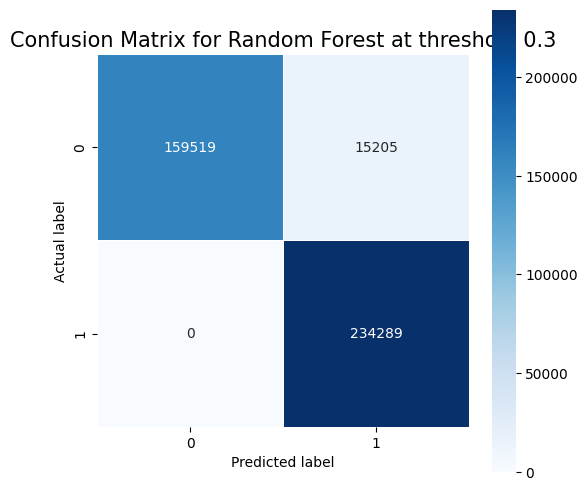

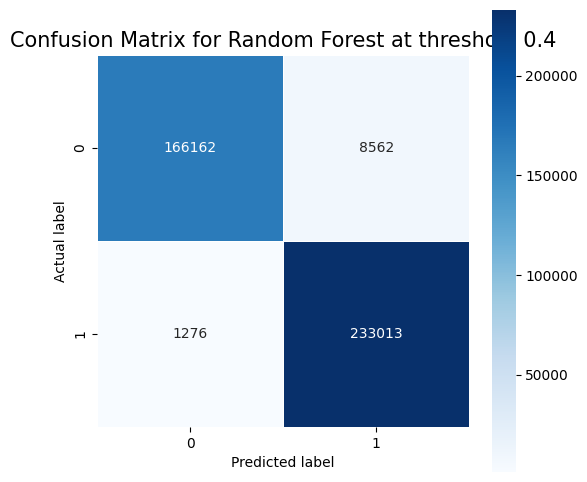

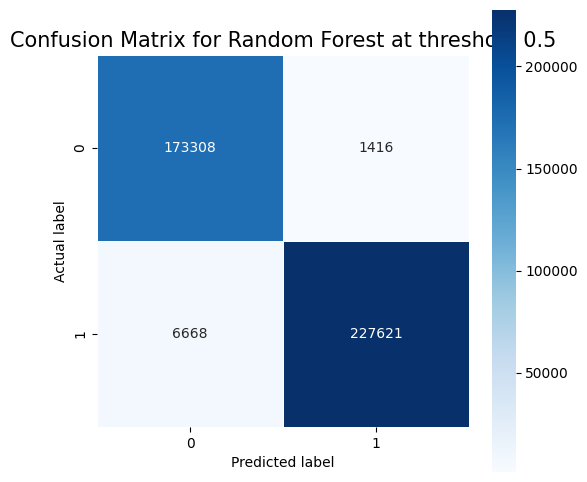

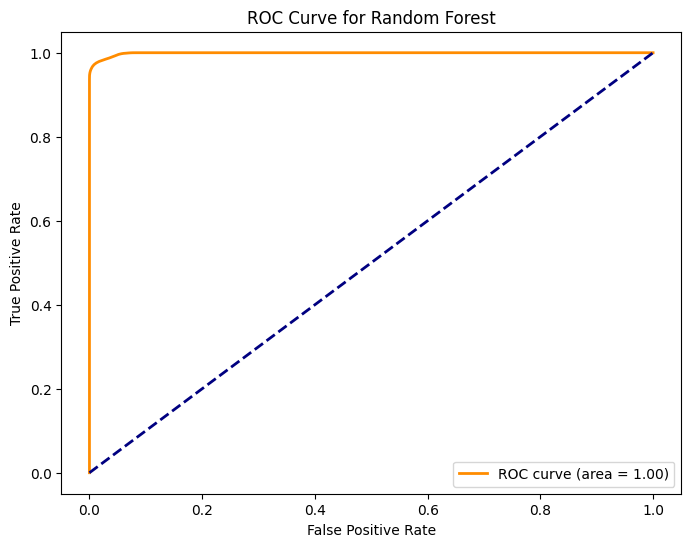

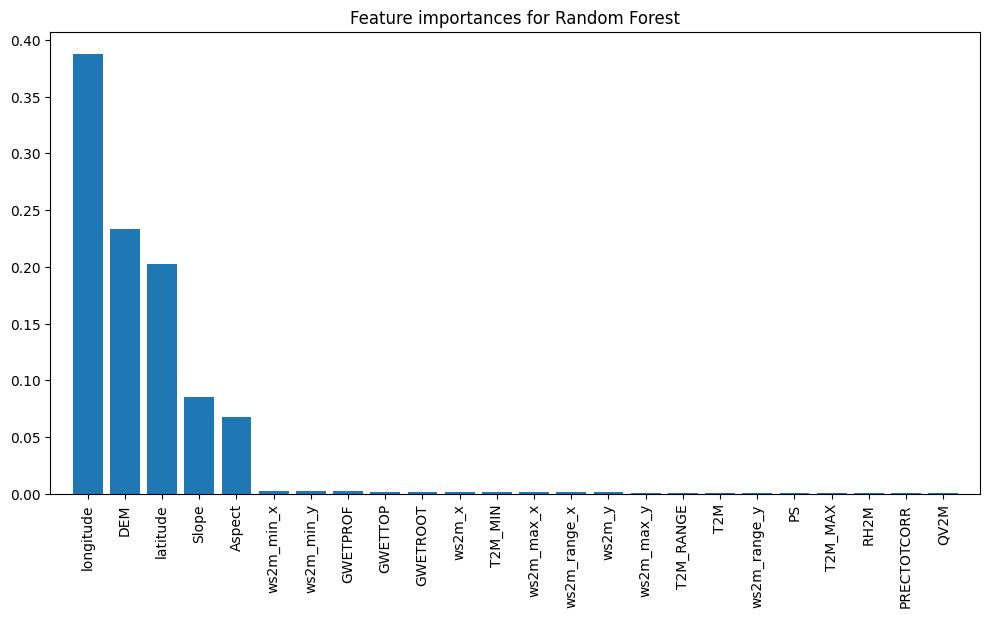

Training...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:52:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost at threshold 0.3:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    174724
           1       0.98      0.97      0.97    234289

    accuracy                           0.97    409013
   macro avg       0.97      0.97      0.97    409013
weighted avg       0.97      0.97      0.97    409013

Cohen Kappa Score for XGBoost at threshold 0.3: 0.9406568081428845
Classification Report for XGBoost at threshold 0.4:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    174724
           1       1.00      0.97      0.98    234289

    accuracy                           0.98    409013
   macro avg       0.98      0.98      0.98    409013
weighted avg       0.98      0.98      0.98    409013

Cohen Kappa Score for XGBoost at threshold 0.4: 0.9605515128303332
Classification Report for XGBoost at threshold 0.5:
              precision    recall  f1-score   support

 

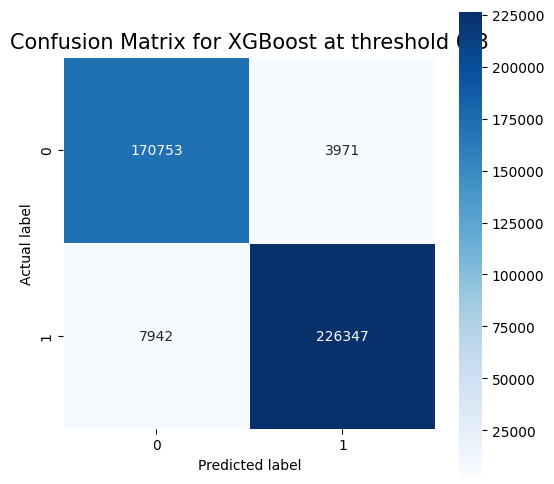

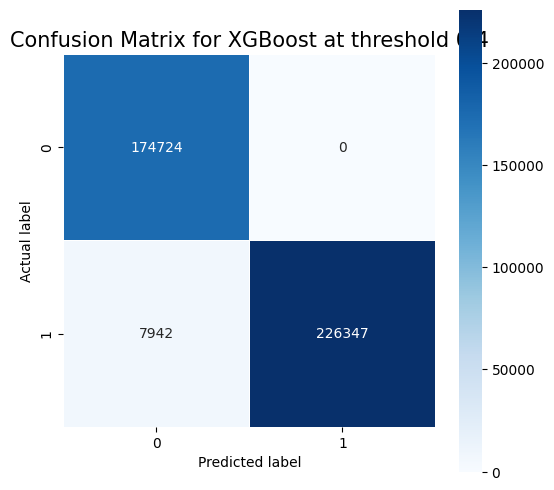

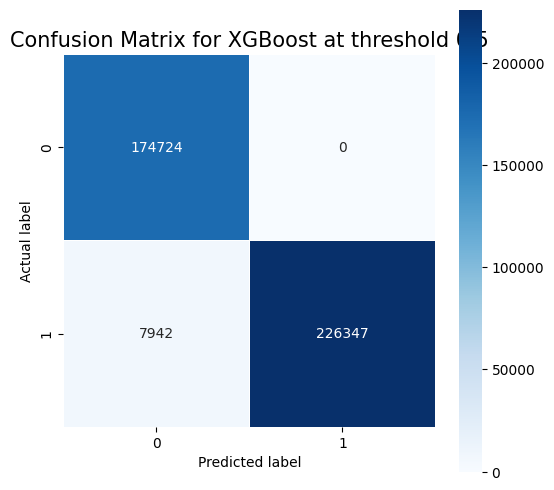

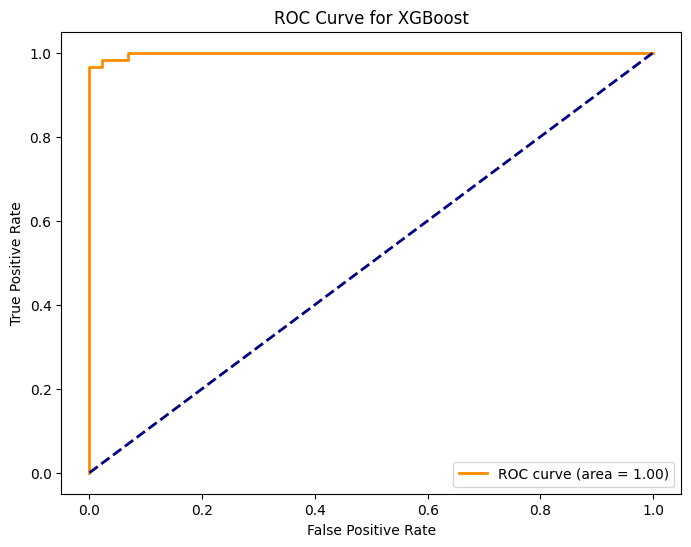

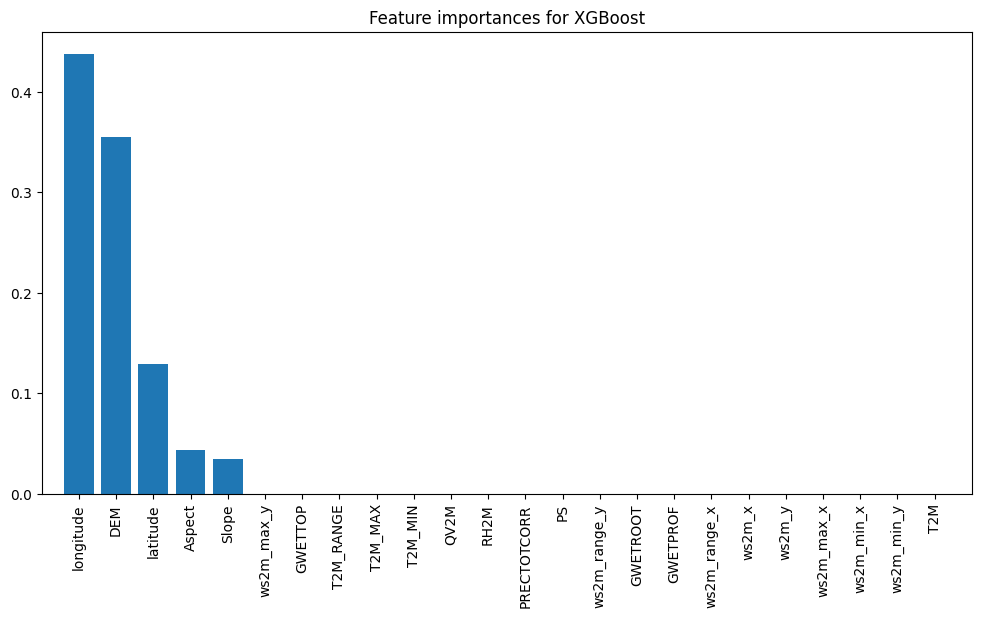

In [ ]:
# Experimenting with the thresholding
thresholds = [0.3, 0.4, 0.5]
# Initialize models
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(random_state=42, device='cuda')
# Train & evaluate the models
train_evaluate_model(rf_model, spenv_X_train, spenv_Y_train, spenv_X_test, spenv_Y_test, "Random Forest", thresholds)
train_evaluate_model(xgb_model, spenv_X_train, spenv_Y_train, spenv_X_test, spenv_Y_test, "XGBoost", thresholds)

**Conclusion: The above model seems to be overly-relying on the longitude. So, I am removing these geographical-realted features and retraining it next.**

---

In [ ]:
spenv_X_train.columns

Index(['T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR',
       'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude', 'longitude', 'DEM',
       'Slope', 'Aspect', 'ws2m_x', 'ws2m_y', 'ws2m_max_x', 'ws2m_max_y',
       'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x', 'ws2m_range_y'],
      dtype='object')

Training...
Classification Report for Random Forest at threshold 0.3:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85    174724
           1       0.85      0.96      0.90    234289

    accuracy                           0.88    409013
   macro avg       0.90      0.87      0.88    409013
weighted avg       0.89      0.88      0.88    409013

Cohen Kappa Score for Random Forest at threshold 0.3: 0.7570970970088303
Classification Report for Random Forest at threshold 0.4:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87    174724
           1       0.88      0.93      0.91    234289

    accuracy                           0.89    409013
   macro avg       0.89      0.89      0.89    409013
weighted avg       0.89      0.89      0.89    409013

Cohen Kappa Score for Random Forest at threshold 0.4: 0.7782963748455601
Classification Report for Random Forest at threshold 0.5:
              

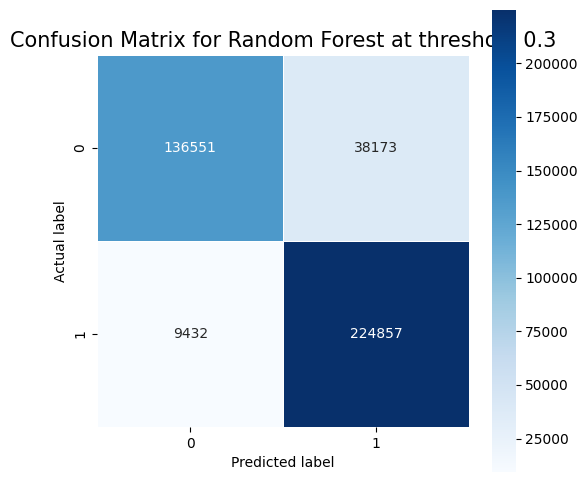

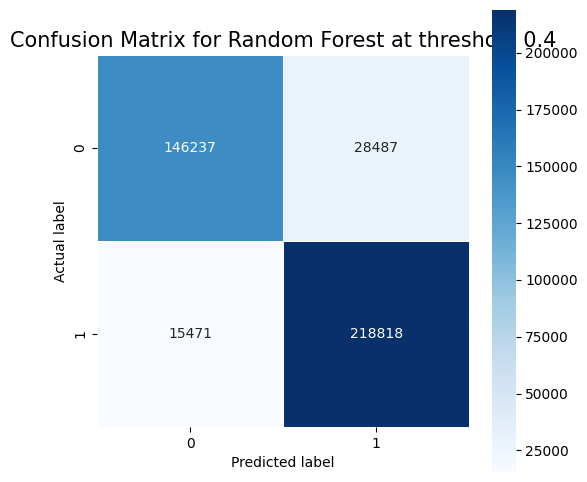

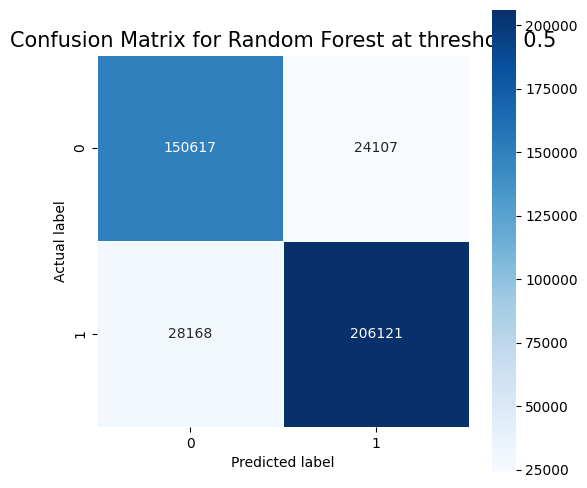

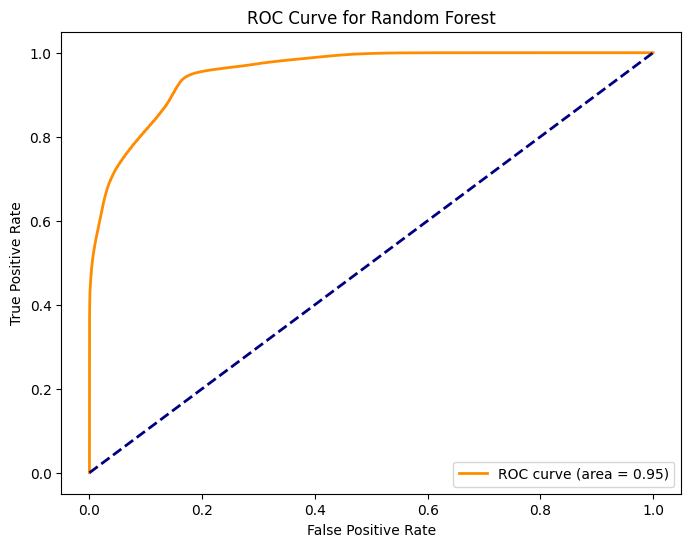

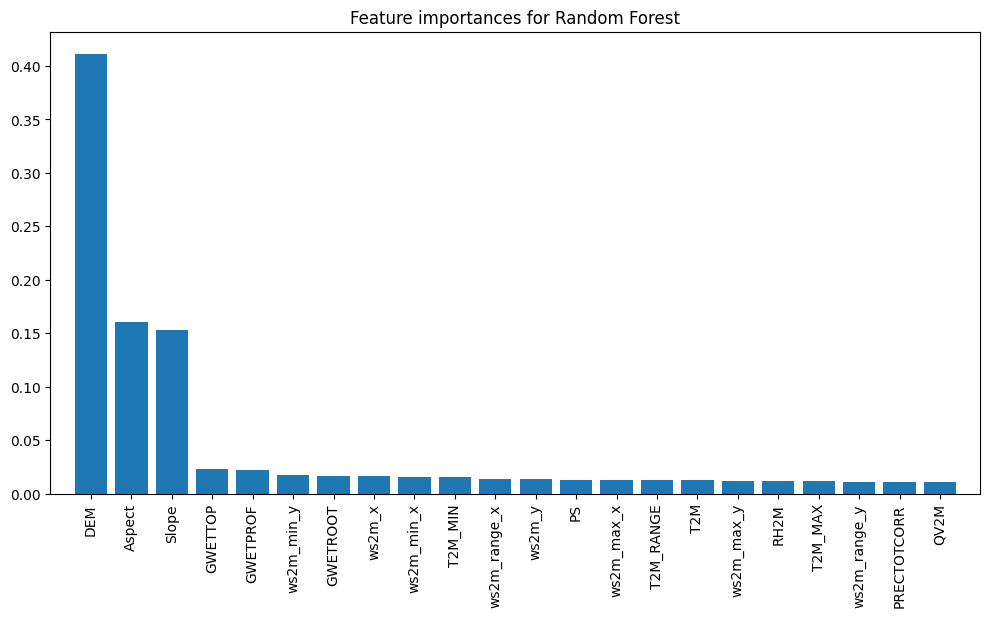

Training...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:26:41] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost at threshold 0.3:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83    174724
           1       0.89      0.84      0.86    234289

    accuracy                           0.85    409013
   macro avg       0.84      0.85      0.85    409013
weighted avg       0.85      0.85      0.85    409013

Cohen Kappa Score for XGBoost at threshold 0.3: 0.6920231129309062
Classification Report for XGBoost at threshold 0.4:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82    174724
           1       0.89      0.82      0.86    234289

    accuracy                           0.84    409013
   macro avg       0.84      0.85      0.84    409013
weighted avg       0.85      0.84      0.84    409013

Cohen Kappa Score for XGBoost at threshold 0.4: 0.6822041423912049
Classification Report for XGBoost at threshold 0.5:
              precision    recall  f1-score   support

 

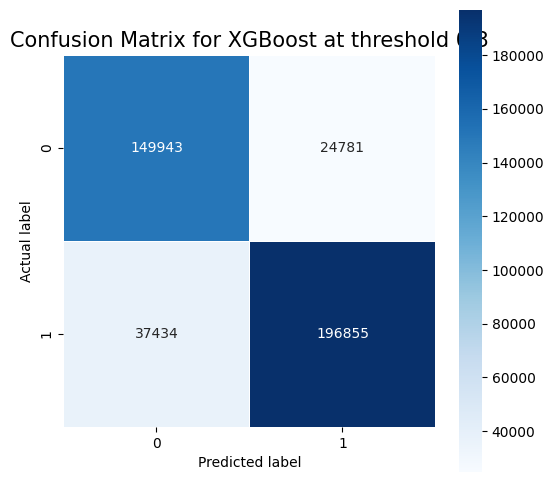

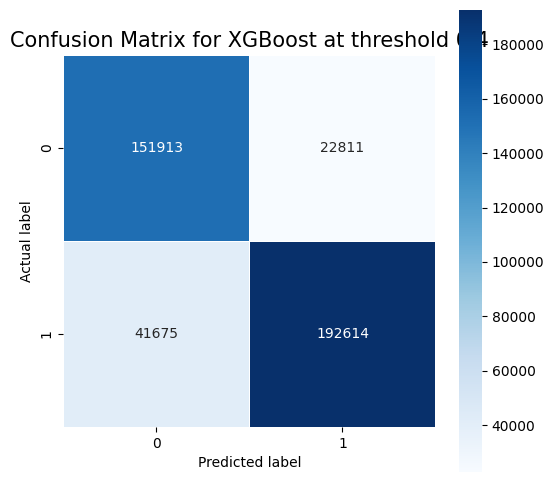

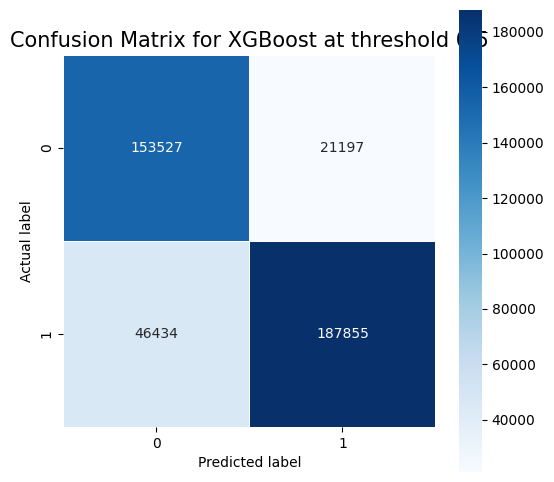

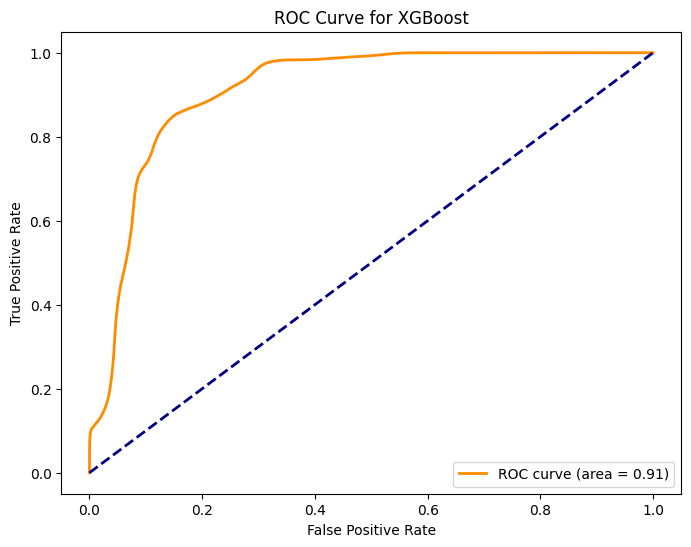

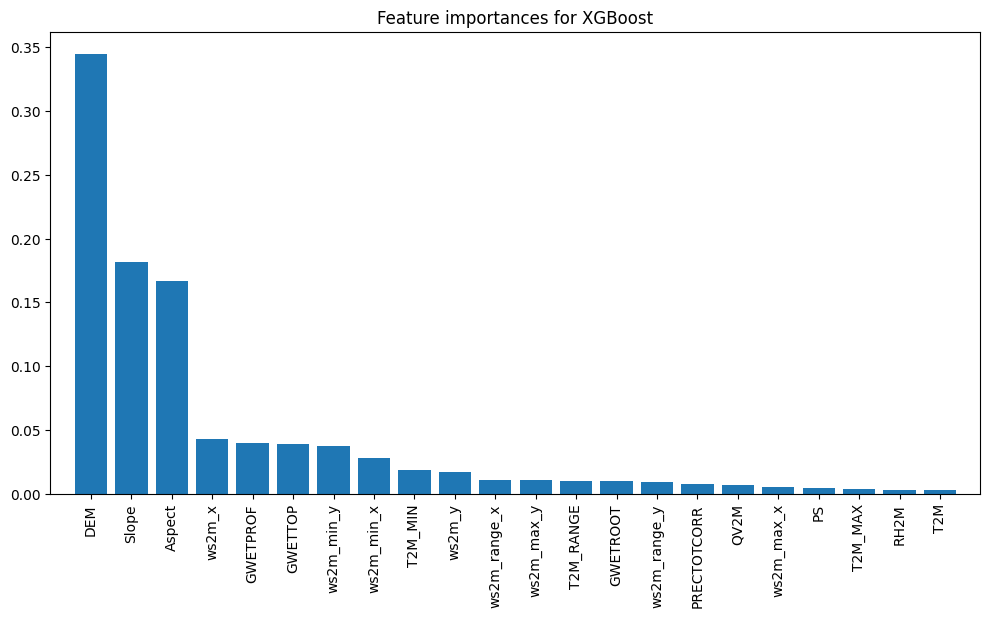

In [ ]:
# Experimenting with the thresholding
thresholds = [0.3, 0.4, 0.5]
# Initialize models
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(random_state=42, device='cuda')

spenv_X_train_noloc = spenv_X_train.drop(columns=['latitude', 'longitude'])
spenv_X_test_noloc = spenv_X_test.drop(columns=['latitude', 'longitude'])

# Train & evaluate the models
train_evaluate_model(rf_model, spenv_X_train_noloc, spenv_Y_train, spenv_X_test_noloc, spenv_Y_test, "Random Forest", thresholds)
train_evaluate_model(xgb_model, spenv_X_train_noloc, spenv_Y_train, spenv_X_test_noloc, spenv_Y_test, "XGBoost", thresholds)

**Conclusion:**

* Removing latitude & longitude results in more realistic metrics that's likely
  to generalize better.
* Based on the model feature importance, the spatial fatures strong predictors of the flood
* From this basic training, the Random Forest is a better than XGBoost given higher Cohen Kappa Score & ROC (Threshold of 0.4 seems like a good compromise)

**Further improvements:**
* Include more relevant topographical/hydrological features
* Experiment with hyperparameter search


In [ ]:
# Saving the model
from joblib import dump

# Assuming your Random Forest model is stored in a variable named 'rf_model'
dump(rf_model, '/content/drive/MyDrive/GIS Data Analysis/random_forest_model.joblib')

['/content/drive/MyDrive/GIS Data Analysis/random_forest_model.joblib']

## 2) Temporal Model

In [ ]:
df_p.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
# I made a mistake earlier in my calculation
df_p.drop(columns=['precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'], inplace=True)

**Select one flood and non-flood locations in Dhaka for time-series**

In [ ]:
noflood_latitude = 23.00
noflood_longitude = 89.75

tolerance = 0.05

# Find rows where the latitude and longitude are within the specified tolerance of the target locati
noflood_df = df_p[
    (df_p['latitude'].between(noflood_latitude - tolerance, noflood_latitude + tolerance)) &
    (df_p['longitude'].between(noflood_longitude - tolerance, noflood_longitude + tolerance))
]

In [ ]:
# Sanity Check
noflood_df[['latitude', 'longitude', 'Flood']].drop_duplicates()

latitude  longitude  Flood
Date                                   
2013-01-01  23.008423  89.762113      0

In [ ]:
flood_latitude = 24.311131
flood_longitude = 91.093680

tolerance = 0.005

# Find rows where the latitude and longitude are within the specified tolerance of the target locati
flood_df = df_p[
    (df_p['latitude'].between(flood_latitude - tolerance, flood_latitude + tolerance)) &
    (df_p['longitude'].between(flood_longitude - tolerance, flood_longitude + tolerance))
]

In [ ]:
# Sanity Check
flood_df[['latitude', 'longitude', 'Flood']].drop_duplicates()

latitude  longitude  Flood
Date                                   
2013-01-01  24.311131   91.09368      1

**Precipitation Feature Engineering: Accumulate rain from past three days**

In [ ]:
window_size = 3
# Shifting is important to prevent the current day's rainfall itself
# Calculate the rolling sum of the past 3 days of precipitation, not including the current day
flood_df['precip_sum'] = flood_df['PRECTOTCORR'].rolling(window=window_size, min_periods=1).sum().shift(1)
# Make sense to fill the first value with 0
flood_df['precip_sum'] = flood_df['precip_sum'].fillna(0)

In [ ]:
noflood_df['precip_sum'] = noflood_df['PRECTOTCORR'].rolling(window=window_size, min_periods=1).sum().shift(1)
# Make sense to fill the first value with 0
noflood_df['precip_sum'] = noflood_df['precip_sum'].fillna(0)

**Soil Saturation:**  Capture the average change in soil wetness over a specified window of time (3 days in this case). These features are designed to help identify trends in soil wetness that may indicate an increasing risk of flooding or drying conditions.

In [ ]:
soil_window_size = 3

# Calculate the rolling change average for each soil wetness feature
flood_df['GWETTOP_rolling_change'] = flood_df['GWETTOP'].diff().rolling(window=soil_window_size).mean().shift(1)
flood_df['GWETROOT_rolling_change'] = flood_df['GWETROOT'].diff().rolling(window=soil_window_size).mean().shift(1)
flood_df['GWETPROF_rolling_change'] = flood_df['GWETPROF'].diff().rolling(window=soil_window_size).mean().shift(1)

# Fill the NaN with 0
flood_df['GWETTOP_rolling_change'] = flood_df['GWETTOP_rolling_change'].fillna(0)
flood_df['GWETROOT_rolling_change'] = flood_df['GWETROOT_rolling_change'].fillna(0)
flood_df['GWETPROF_rolling_change'] = flood_df['GWETPROF_rolling_change'].fillna(0)

# Calculate the rolling change average for each soil wetness feature
noflood_df['GWETTOP_rolling_change'] = noflood_df['GWETTOP'].diff().rolling(window=soil_window_size).mean().shift(1)
noflood_df['GWETROOT_rolling_change'] = noflood_df['GWETROOT'].diff().rolling(window=soil_window_size).mean().shift(1)
noflood_df['GWETPROF_rolling_change'] = noflood_df['GWETPROF'].diff().rolling(window=soil_window_size).mean().shift(1)

# Fill the NaN with 0
noflood_df['GWETTOP_rolling_change'] = noflood_df['GWETTOP_rolling_change'].fillna(0)
noflood_df['GWETROOT_rolling_change'] = noflood_df['GWETROOT_rolling_change'].fillna(0)
noflood_df['GWETPROF_rolling_change'] = noflood_df['GWETPROF_rolling_change'].fillna(0)

<ipython-input-94-9548f6f70d8c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['GWETTOP_rolling_change'] = flood_df['GWETTOP'].diff().rolling(window=soil_window_size).mean().shift(1)
<ipython-input-94-9548f6f70d8c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['GWETROOT_rolling_change'] = flood_df['GWETROOT'].diff().rolling(window=soil_window_size).mean().shift(1)
<ipython-input-94-9548f6f70d8c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
flood_df.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
noflood_df.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
combined_df = pd.concat([flood_df, noflood_df])

# Sort the combined DataFrame by 'YEAR' and 'DOY' to ensure proper chronological order
combined_df.sort_values(by=['YEAR', 'DOY'], inplace=True)

In [ ]:
combined_df.head(15)

In [ ]:
# Some of the devised
corr_matrix = combined_df.corr()
corr_matrix['Flood'].sort_values(ascending=False)

Aspect                     1.000000e+00
Flood                      1.000000e+00
latitude                   1.000000e+00
longitude                  1.000000e+00
ws2m_max_y                 1.165354e-01
ws2m_min_y                 1.142929e-01
precip_sum                 1.118827e-01
ws2m_range_y               1.104415e-01
ws2m_y                     1.031934e-01
PRECTOTCORR                9.229771e-02
GWETTOP                    7.944767e-02
RH2M                       3.477930e-02
GWETROOT                   1.436664e-02
QV2M                       2.231087e-03
YEAR                       3.059500e-15
DOY                        1.653437e-16
sin_DOY                   -1.165351e-16
cos_DOY                   -1.375931e-16
GWETTOP_rolling_change    -2.556289e-04
GWETROOT_rolling_change   -9.758497e-04
GWETPROF_rolling_change   -1.178392e-03
PS                        -8.611092e-03
T2M_RANGE                 -1.594053e-02
GWETPROF                  -2.442087e-02
T2M_MIN                   -3.685880e-02


In [ ]:
combined_df.columns

Index(['YEAR', 'DOY', 'T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'latitude',
       'longitude', 'DEM', 'Slope', 'Aspect', 'Flood', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change'],
      dtype='object')

In [ ]:
combined_df.shape

(7942, 33)

In [ ]:
temp_features = ['T2M', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M',
       'PRECTOTCORR', 'PS', 'GWETTOP', 'GWETROOT', 'GWETPROF', 'ws2m_x', 'ws2m_y',
       'ws2m_max_x', 'ws2m_max_y', 'ws2m_min_x', 'ws2m_min_y', 'ws2m_range_x',
       'ws2m_range_y', 'sin_DOY', 'cos_DOY', 'precip_sum',
       'GWETTOP_rolling_change', 'GWETROOT_rolling_change',
       'GWETPROF_rolling_change']
label = ['Flood']

In [ ]:
combined_df.head()

YEAR  DOY    T2M  T2M_RANGE  T2M_MAX  T2M_MIN  QV2M   RH2M  \
Date                                                                     
2013-01-01  2013    1  16.55      14.43    24.88    10.45  7.57  67.00   
2013-01-01  2013    1  17.34      14.55    24.73    10.17  7.08  59.50   
2013-01-02  2013    2  17.34      14.45    25.97    11.51  7.93  67.50   
2013-01-02  2013    2  18.52      13.12    25.68    12.55  8.12  63.19   
2013-01-03  2013    3  16.90       9.56    21.39    11.83  8.73  73.69   

            PRECTOTCORR      PS  ...  ws2m_min_x  ws2m_min_y  ws2m_range_x  \
Date                             ...                                         
2013-01-01          0.0  101.17  ...   -0.180474   -0.288148     -0.716590   
2013-01-01          0.0  101.23  ...    0.720325   -0.505502      1.031374   
2013-01-02          0.0  101.23  ...   -0.077661   -0.227088     -0.569513   
2013-01-02          0.0  101.28  ...    0.022954   -0.429387      0.053916   
2013-01-03          0.0  101.35  ...   -0.545919   -0.438146     -1.395993   

            ws2m_range_y   sin_DOY   cos_DOY  precip_sum  \
Date                                                       
2013-01-01     -1.144115  0.017213  0.999852         0.0   
2013-01-01     -0.723787  0.017213  0.999852         0.0   
2013-01-02     -1.665309  0.034422  0.999407         0.0   
2013-01-02     -1.008560  0.034422  0.999407         0.0   
2013-01-03     -1.120403  0.051620  0.998667         0.0   

            GWETTOP_rolling_change  GWETROOT_rolling_change  \
Date                                                          
2013-01-01                     0.0                      0.0   
2013-01-01                     0.0                      0.0   
2013-01-02                     0.0                      0.0   
2013-01-02                     0.0                      0.0   
2013-01-03                     0.0                      0.0   

            GWETPROF_rolling_change  
Date                                 
2013-01-01                      0.0  
2013-01-01                      0.0  
2013-01-02                      0.0  
2013-01-02                      0.0  
2013-01-03                      0.0  

[5 rows x 33 columns]

Training and evaluating Random Forest for test years 2021 to 2023
Training...
Classification Report for Random Forest at threshold 0.4:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75      1049
           1       0.72      0.94      0.82      1049

    accuracy                           0.79      2098
   macro avg       0.82      0.79      0.78      2098
weighted avg       0.82      0.79      0.78      2098

Cohen Kappa Score for Random Forest at threshold 0.4: 0.5767397521448999


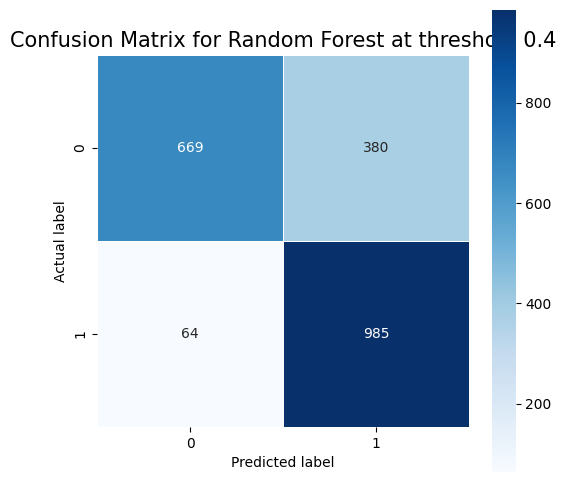

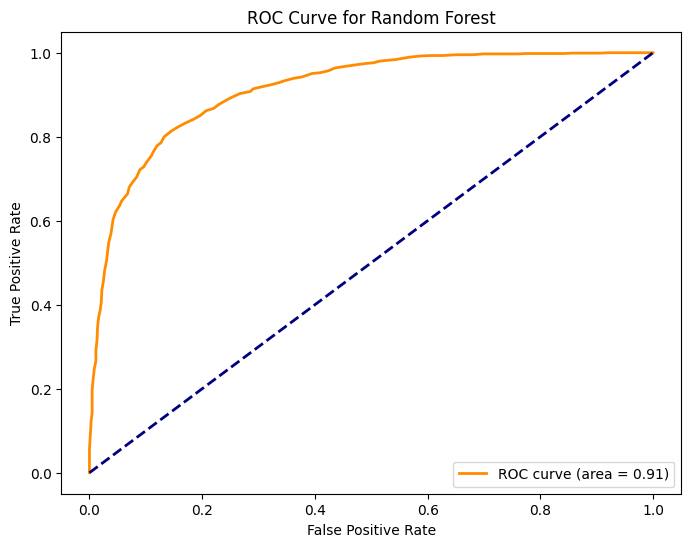

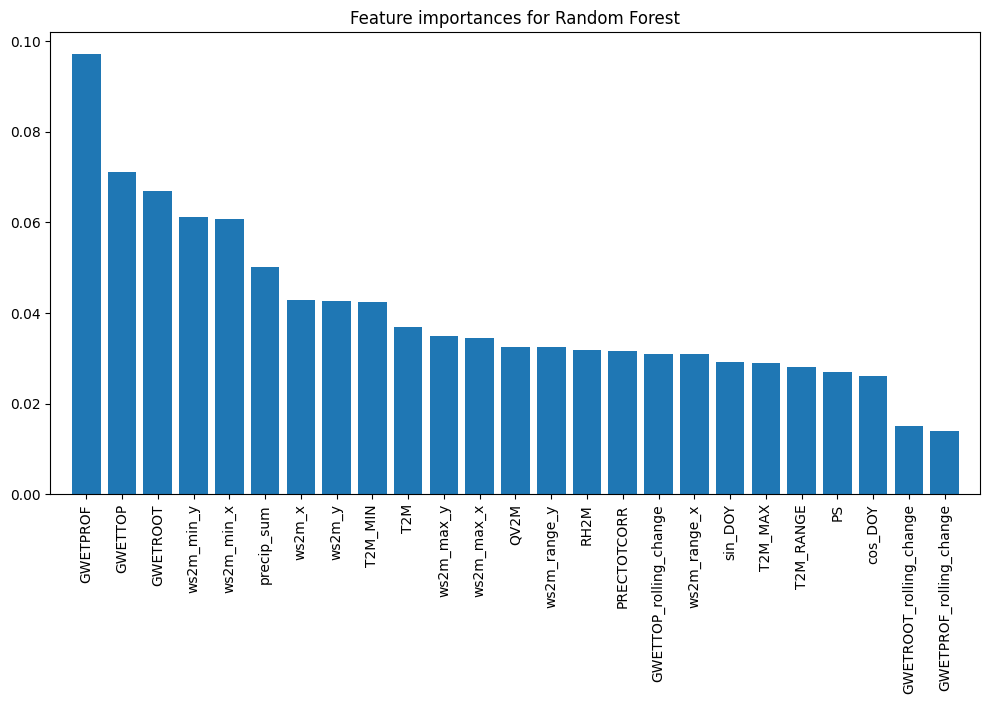

Training and evaluating XGBoost for test years 2021 to 2023
Training...
Classification Report for XGBoost at threshold 0.4:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1049
           1       0.92      0.95      0.93      1049

    accuracy                           0.93      2098
   macro avg       0.93      0.93      0.93      2098
weighted avg       0.93      0.93      0.93      2098

Cohen Kappa Score for XGBoost at threshold 0.4: 0.8617731172545281


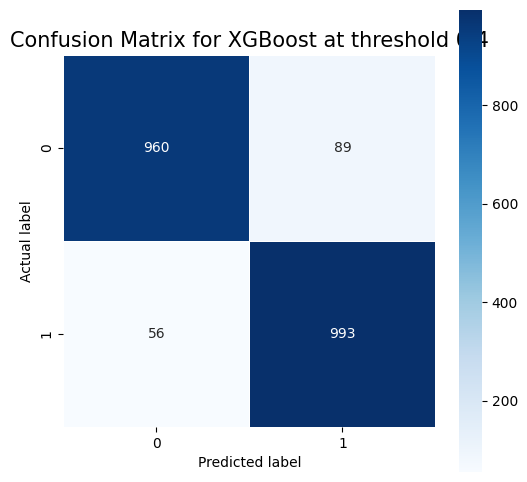

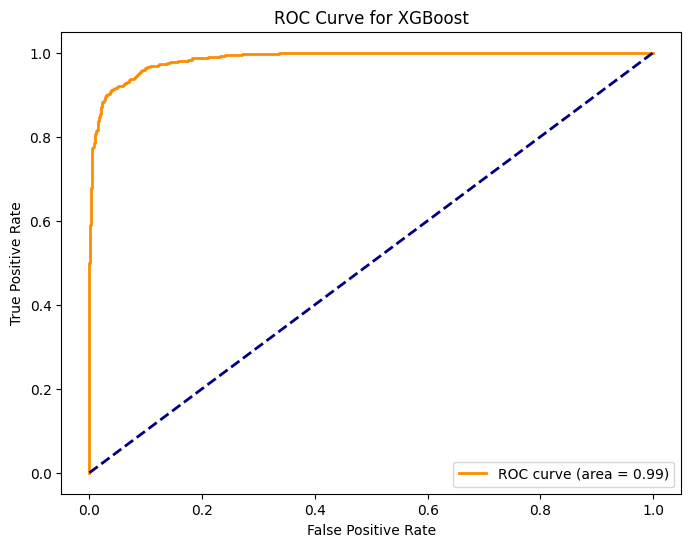

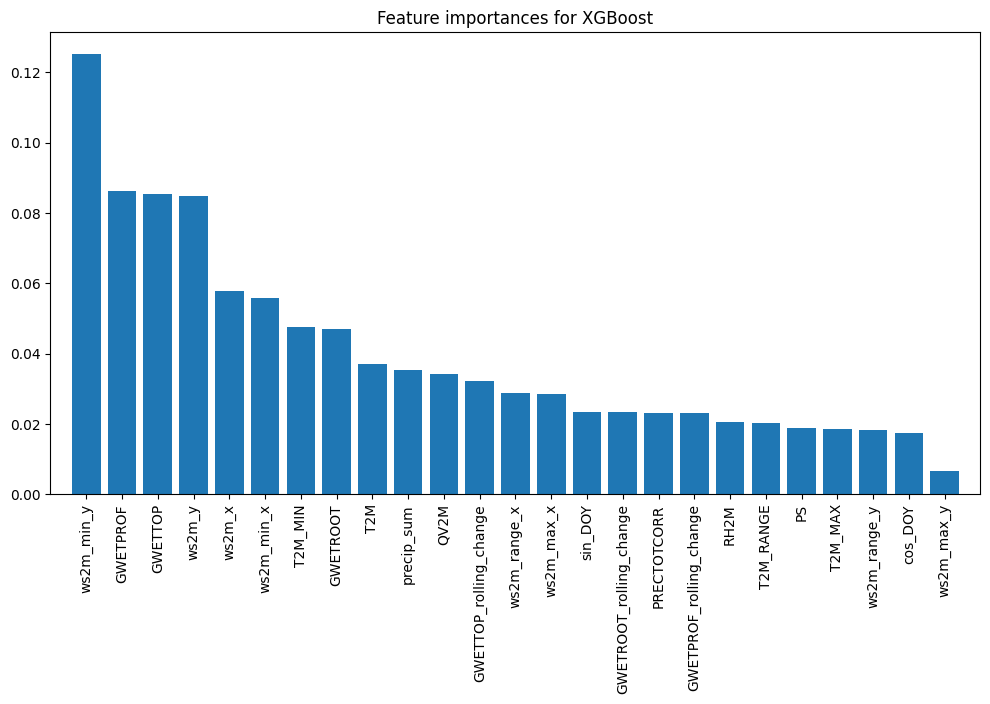

In [ ]:
rf_model_tmp = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb_model_tmp = XGBClassifier(random_state=42)

# Define the thresholds for evaluation
thresholds = [0.4]

# Define the range for the rolling window validation
training_start_year = 2013
test_start_year = 2021
testing_end_year = 2023

# Create the training and testing sets based on the year
X_train = combined_df[(combined_df['YEAR'] >= training_start_year) &
 (combined_df['YEAR'] < test_start_year)][temp_features]
y_train = combined_df[(combined_df['YEAR'] >= training_start_year) &
 (combined_df['YEAR'] < test_start_year)][label]
X_test = combined_df[(combined_df['YEAR'] >= test_start_year) &
 (combined_df['YEAR'] <= testing_end_year)][temp_features]
y_test = combined_df[(combined_df['YEAR'] >= test_start_year) &
 (combined_df['YEAR'] <= testing_end_year)][label]

# Train and evaluate Random Forest
print(f"Training and evaluating Random Forest for test years {test_start_year} to {testing_end_year}")
train_evaluate_model(rf_model_tmp, X_train, y_train, X_test, y_test, "Random Forest", thresholds)

# Train and evaluate XGBoost
print(f"Training and evaluating XGBoost for test years {test_start_year} to {testing_end_year}")
train_evaluate_model(xgb_model_tmp, X_train, y_train, X_test, y_test, "XGBoost", thresholds)

**Conclusion of the best model**

**BEST: XGBoost**

1. High Precision for both classes.
2. Recall Balanced between two classes
3. False Positives (89) and False Negatives(56) are low.
4. AUC of 0.99 (Almost perfeect at separating two classes)
5. Day of the year & Preciptation not as important as I imagined
6. High F-1 Score: Balanced ability to predict both flood & non-flood events.
7. High Cohen Kappa Score: 0.86 (Strong agreement between prediction and actual labels)

**Strong Predictive Power**

**Further Improvement and Work**

1. Hyperparameter tuning
2. Perform test on other geographic locations (Does the model genrealize well?)

